In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from optbinning import BinningProcess

# set col width
pd.set_option('display.max_colwidth', 100)

# set plot style
plt.style.use('seaborn-whitegrid')

# set palette
sns.set_palette('Set1')

(CVXPY) Dec 14 03:41:07 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 14 03:41:07 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/4023470249.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def create_features(df):
    new_features = {
        'VERSION_CHANGE': df.groupby('SK_ID_PREV')['NUM_INSTALMENT_VERSION'].diff().fillna(0),
        'TIMING_DIFF': df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT'],
        'PAYMENT_RATIO': df['AMT_PAYMENT'] / df['AMT_INSTALMENT'],
        'PAYMENT_DIFF': df['AMT_INSTALMENT'] - df['AMT_PAYMENT'],
        'DUE_FLAG': df['DAYS_ENTRY_PAYMENT'] > df['DAYS_INSTALMENT'],
        'DPD_RATIO': df['DAYS_ENTRY_PAYMENT'] / df['DAYS_INSTALMENT'],
        'DPD_DIFF': df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT'],
        'MOVING_AVG_PAYMENT': df.groupby('SK_ID_PREV')['AMT_PAYMENT'].rolling(3).mean().fillna(0).reset_index(0, drop=True),
        'MOVING_AVG_INSTALMENT': df.groupby('SK_ID_PREV')['AMT_INSTALMENT'].rolling(3).mean().fillna(0).reset_index(0, drop=True),
        'TOTAL_PAID_SO_FAR': df.groupby('SK_ID_PREV')['AMT_PAYMENT'].cumsum().fillna(0),
        'TOTAL_INSTALMENT_SO_FAR': df.groupby('SK_ID_PREV')['AMT_INSTALMENT'].cumsum().fillna(0),
        'PAYMENT_REGULARITY': df.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].diff().fillna(0),
        'DELAYED_PAYMENT_COUNT': df.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].apply(lambda x: x > 0).sum(),
        'VERSION_PAYMENT_INTERACTION': df.groupby('SK_ID_PREV')['NUM_INSTALMENT_VERSION'].apply(lambda x: x > 1).sum(),
        'INSTALLMENT_COUNT': df.groupby('SK_ID_PREV').size().fillna(0),
        'INSTALLMENT_FIRST_DUE_DIFF': df.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].first() - df.groupby('SK_ID_PREV')['DAYS_INSTALMENT'].first().fillna(0),
        'INSTALLMENT_LAST_DUE_DIFF': df.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].last() - df.groupby('SK_ID_PREV')['DAYS_INSTALMENT'].last().fillna(0),
    }


    df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    return df

In [3]:
# Load data
df = pd.read_csv('../raw-data/dseb63_installments_payments.csv')
df = df.sort_values(['SK_ID_PREV', 'DAYS_INSTALMENT']).reset_index(drop=True)
df_copy = df.copy()
df.head()

SK_ID_PREV  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
0     1000001                     1.0                      1           -268.0   
1     1000001                     2.0                      2           -238.0   
2     1000003                     1.0                      1            -94.0   
3     1000003                     1.0                      2            -64.0   
4     1000003                     1.0                      3            -34.0   

   DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  SK_ID_CURR  
0              -294.0        6404.310     6404.310    117953.0  
1              -244.0       62039.115    62039.115    117953.0  
2              -108.0        4951.350     4951.350      6707.0  
3               -81.0        4951.350     4951.350      6707.0  
4               -49.0        4951.350     4951.350      6707.0

In [4]:
target = pd.read_csv('../processed-data/target.csv')
target.head()

SK_ID_CURR  TARGET
0           0       0
1           1       1
2           2       0
3           3       0
4           4       0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744758 entries, 0 to 7744757
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
 7   SK_ID_CURR              float64
dtypes: float64(6), int64(2)
memory usage: 472.7 MB


In [6]:
df = create_features(df)
df

SK_ID_PREV  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0           1000001                     1.0                      1   
1           1000001                     2.0                      2   
2           1000003                     1.0                      1   
3           1000003                     1.0                      2   
4           1000003                     1.0                      3   
...             ...                     ...                    ...   
7744753     2843495                     1.0                      3   
7744754     2843495                     1.0                      4   
7744755     2843495                     1.0                      5   
7744756     2843495                     1.0                      6   
7744757     2843495                     2.0                      7   

         DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  \
0                 -268.0              -294.0        6404.310     6404.310   
1                 -238.0              -244.0       62039.115    62039.115   
2                  -94.0              -108.0        4951.350     4951.350   
3                  -64.0               -81.0        4951.350     4951.350   
4                  -34.0               -49.0        4951.350     4951.350   
...                  ...                 ...             ...          ...   
7744753           -379.0              -384.0       23556.195    23556.195   
7744754           -349.0              -349.0       23556.195    23556.195   
7744755           -319.0              -320.0       23556.195    23556.195   
7744756           -289.0              -288.0       23556.195    23556.195   
7744757           -259.0              -264.0      656193.015   656193.015   

         SK_ID_CURR  VERSION_CHANGE  TIMING_DIFF  ...  MOVING_AVG_PAYMENT  \
0          117953.0             0.0        -26.0  ...               0.000   
1          117953.0             1.0         -6.0  ...               0.000   
2            6707.0             0.0        -14.0  ...               0.000   
3            6707.0             0.0        -17.0  ...               0.000   
4            6707.0             0.0        -15.0  ...            4951.350   
...             ...             ...          ...  ...                 ...   
7744753    274857.0             0.0         -5.0  ...           23556.195   
7744754    274857.0             0.0          0.0  ...           23556.195   
7744755    274857.0             0.0         -1.0  ...           23556.195   
7744756    274857.0             0.0          1.0  ...           23556.195   
7744757    274857.0             1.0         -5.0  ...          234435.135   

         MOVING_AVG_INSTALMENT  TOTAL_PAID_SO_FAR  TOTAL_INSTALMENT_SO_FAR  \
0                        0.000           6404.310                 6404.310   
1                        0.000          68443.425                68443.425   
2                        0.000           4951.350                 4951.350   
3                        0.000           9902.700                 9902.700   
4                     4951.350          14854.050                14854.050   
...                        ...                ...                      ...   
7744753              23556.195          70668.585                70668.585   
7744754              23556.195          94224.780                94224.780   
7744755              23556.195         117780.975               117780.975   
7744756              23556.195         141337.170               141337.170   
7744757             234435.135         797530.185               797530.185   

         PAYMENT_REGULARITY  DELAYED_PAYMENT_COUNT  \
0                       0.0                      0   
1                      50.0                      0   
2                       0.0                      0   
3                      27.0                      0   
4                      32.0                      0   
...                     ...                    ...   
774

# EDA

In [7]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
# remove sk_id_prev, sk_id_curr
num_cols.remove('SK_ID_PREV')
num_cols.remove('SK_ID_CURR')

cat_cols = df.select_dtypes(include='object').columns.tolist()

## Missing Values


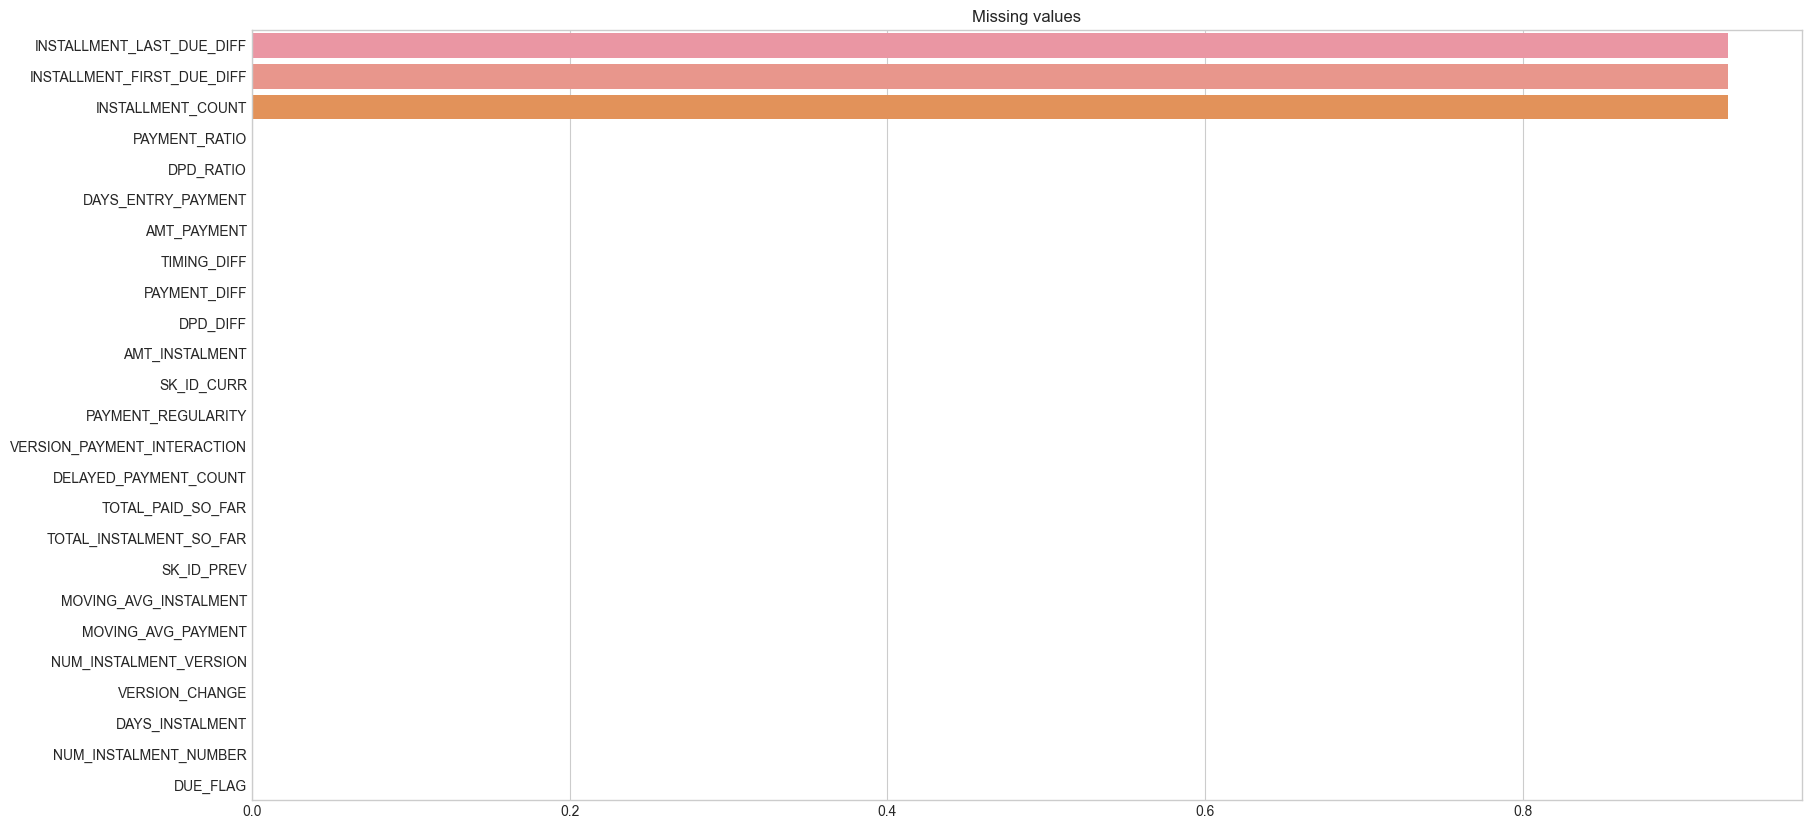

In [8]:
# Horizontal barplot of missing value percentage
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=df.isnull().mean().sort_values(ascending=False), y=df.isnull().mean().sort_values(ascending=False).index, ax=ax)
ax.set_title('Missing values')
plt.show()

## Outliers

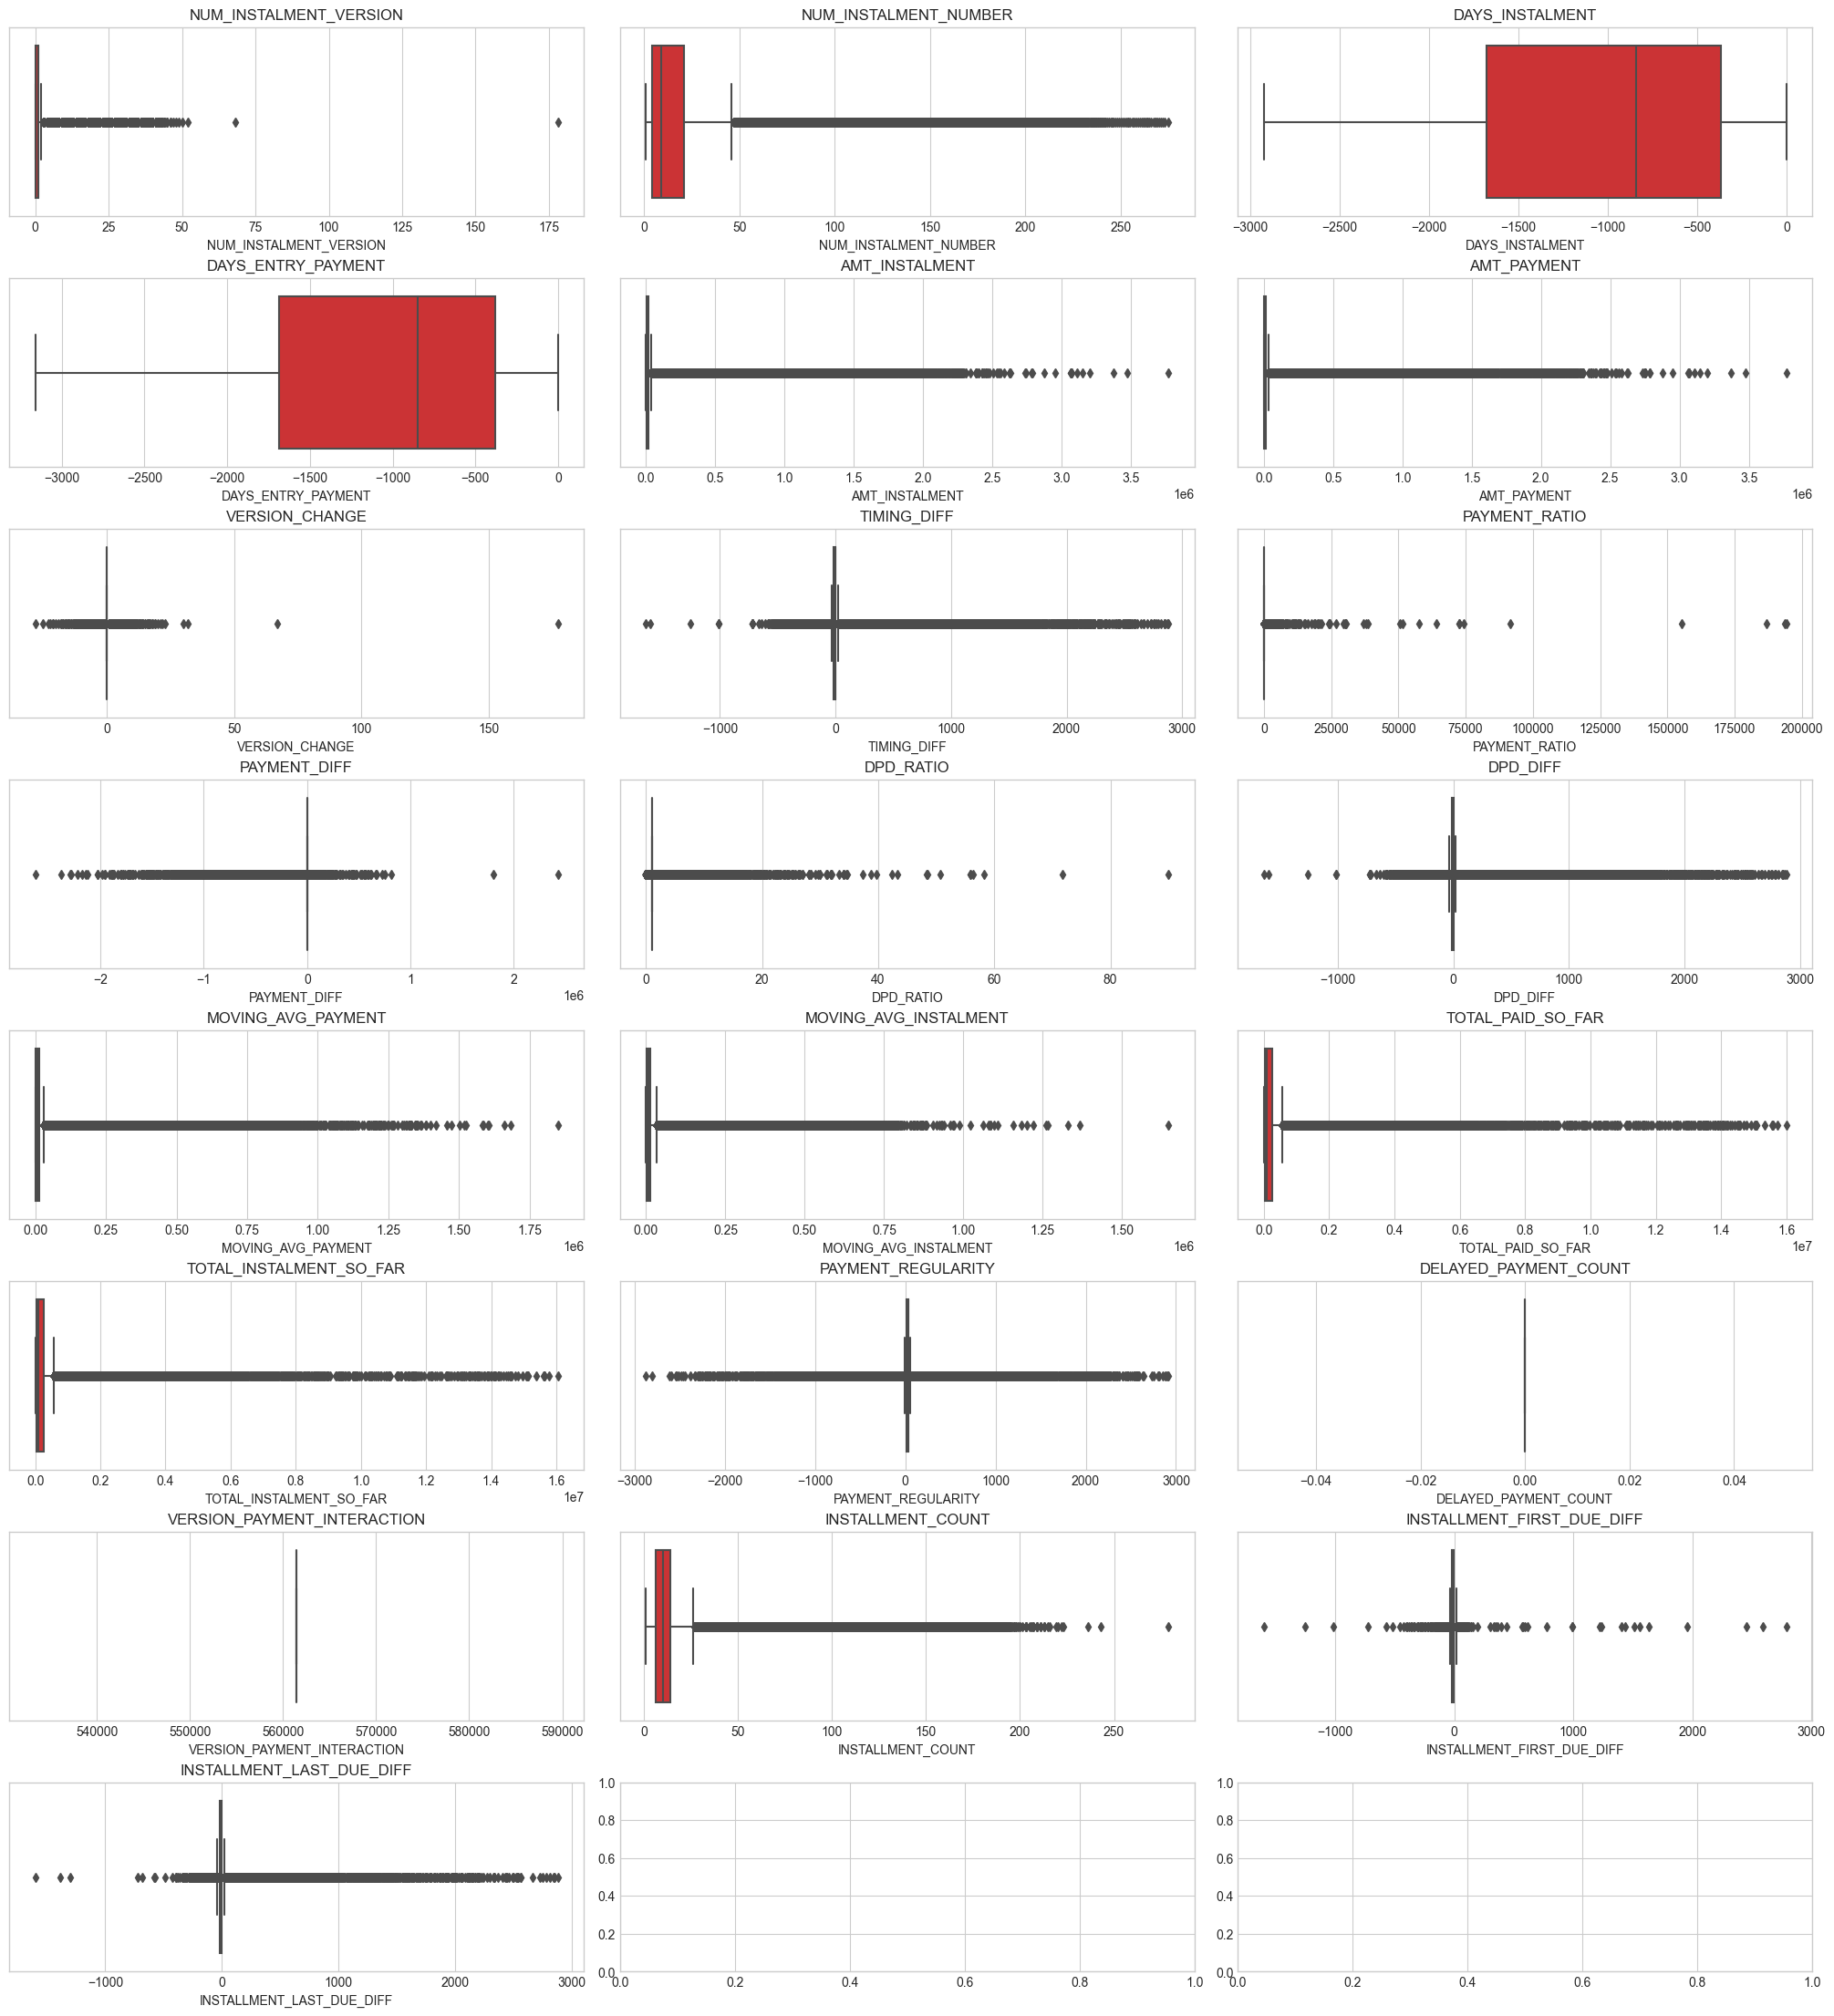

In [9]:
# Boxplot of numerical columns
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)

plt.show()

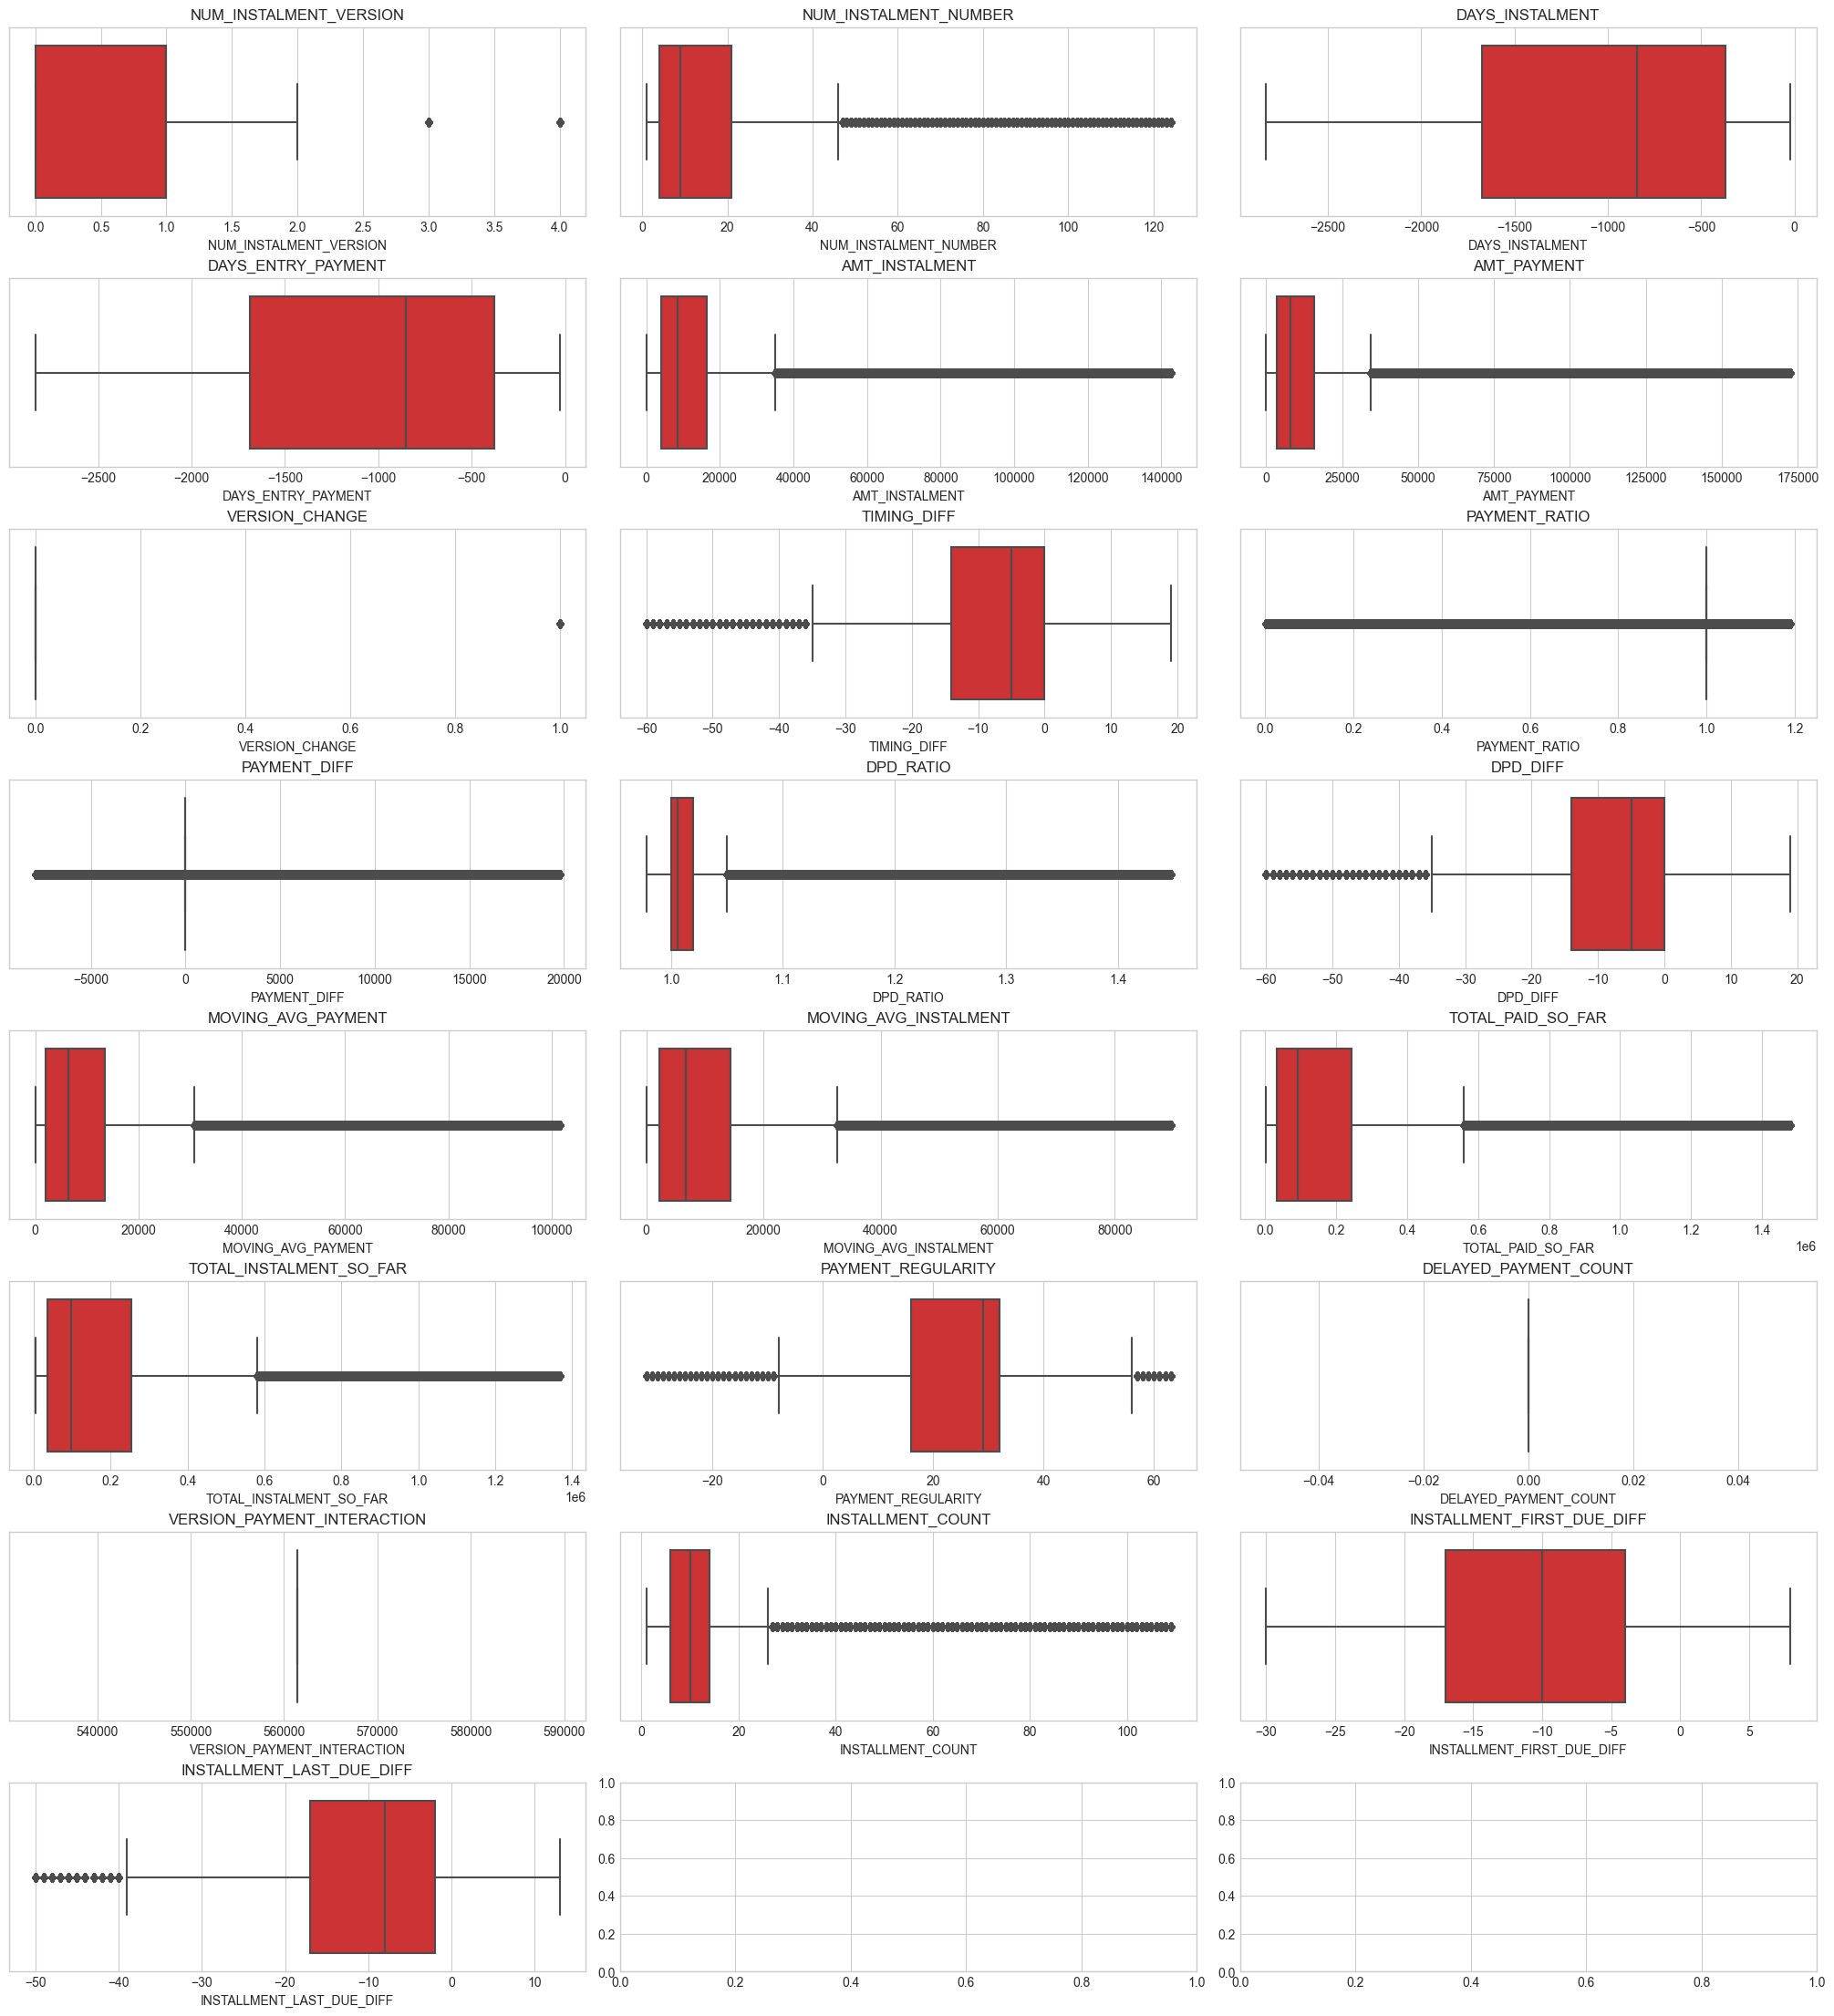

In [10]:
# Clip outliers
for column in num_cols:
    df[column] = df[column].clip(df[column].quantile(0.01), df[column].quantile(0.99))

# Boxplot of numerical columns
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)

plt.show()

## Descriptive

In [11]:
df.describe()

SK_ID_PREV  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
count  7.744758e+06            7.744758e+06           7.744758e+06   
mean   1.902824e+06            7.947706e-01           1.970747e+01   
std    5.360570e+05            7.027051e-01           2.668294e+01   
min    1.000001e+06            0.000000e+00           1.000000e+00   
25%    1.432108e+06            0.000000e+00           4.000000e+00   
50%    1.895642e+06            1.000000e+00           9.000000e+00   
75%    2.368895e+06            1.000000e+00           2.100000e+01   
max    2.843495e+06            4.000000e+00           1.240000e+02   

       DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  \
count     7.744758e+06        7.743119e+06    7.744757e+06  7.743119e+06   
mean     -1.055321e+03       -1.063944e+03    1.423094e+04  1.421608e+04   
std       7.998325e+02        7.994074e+02    1.993404e+04  2.301095e+04   
min      -2.831000e+03       -2.836000e+03    1.161000e+01  3.645000e+00   
25%      -1.677000e+03       -1.686000e+03    4.050000e+03  3.375000e+03   
50%      -8.420000e+02       -8.510000e+02    8.611920e+03  7.906185e+03   
75%      -3.690000e+02       -3.790000e+02    1.641312e+04  1.575000e+04   
max      -2.200000e+01       -2.900000e+01    1.425078e+05  1.725953e+05   

         SK_ID_CURR  VERSION_CHANGE   TIMING_DIFF  ...  MOVING_AVG_PAYMENT  \
count  7.744757e+06    7.744758e+06  7.743119e+06  ...        7.744758e+06   
mean   1.535739e+05    3.765683e-02 -8.759459e+00  ...        1.120483e+04   
std    8.864267e+04    1.903649e-01  1.235994e+01  ...        1.602697e+04   
min    0.000000e+00    0.000000e+00 -6.000000e+01  ...        0.000000e+00   
25%    7.684800e+04    0.000000e+00 -1.400000e+01  ...        1.911000e+03   
50%    1.530760e+05    0.000000e+00 -5.000000e+00  ...        6.321690e+03   
75%    2.301440e+05    0.000000e+00  0.000000e+00  ...        1.345191e+04   
max    3.075080e+05    1.000000e+00  1.900000e+01  ...        1.015716e+05   

       MOVING_AVG_INSTALMENT  TOTAL_PAID_SO_FAR  TOTAL_INSTALMENT_SO_FAR  \
count           7.744758e+06       7.744758e+06             7.744758e+06   
mean            1.150062e+04       1.973393e+05             1.994288e+05   
std             1.515531e+04       2.689128e+05             2.603790e+05   
min             0.000000e+00       3.534647e+03             3.748256e+03   
25%             2.229435e+03       3.372948e+04             3.507274e+04   
50%             6.752700e+03       9.225000e+04             9.633494e+04   
75%             1.435041e+04       2.436775e+05             2.529291e+05   
max             8.953020e+04       1.479605e+06             1.367210e+06   

       PAYMENT_REGULARITY  DELAYED_PAYMENT_COUNT  VERSION_PAYMENT_INTERACTION  \
count        7.744758e+06              7744758.0                    7744758.0   
mean         2.340466e+01                    0.0                     561440.0   
std          1.654378e+01                    0.0                          0.0   
min         -3.200000e+01                    0.0                     561440.0   
25%          1.600000e+01                    0.0                     561440.0   
50%          2.900000e+01                    0.0                     561440.0   
75%          3.200000e+01                    0.0                     561440.0   
max          6.300000e+01                    0.0                     561440.0   

       INSTALLMENT_COUNT  INSTALLMENT_FIRST_DUE_DIFF  \
count      549020.000000               548987.000000   
mean           13.879123                  -11.019101   
std            17.077019                    9.092684   
min             1.000000                  -30.000000   
25%             6.000000                  -17.000000   
50%            10.000000                  -10.000000   
75%            14.000000                   -4.000000   
max           109.000000                    8.000000   

       INSTALLMENT_LAST_DUE_DIFF  
count              548987.000000  


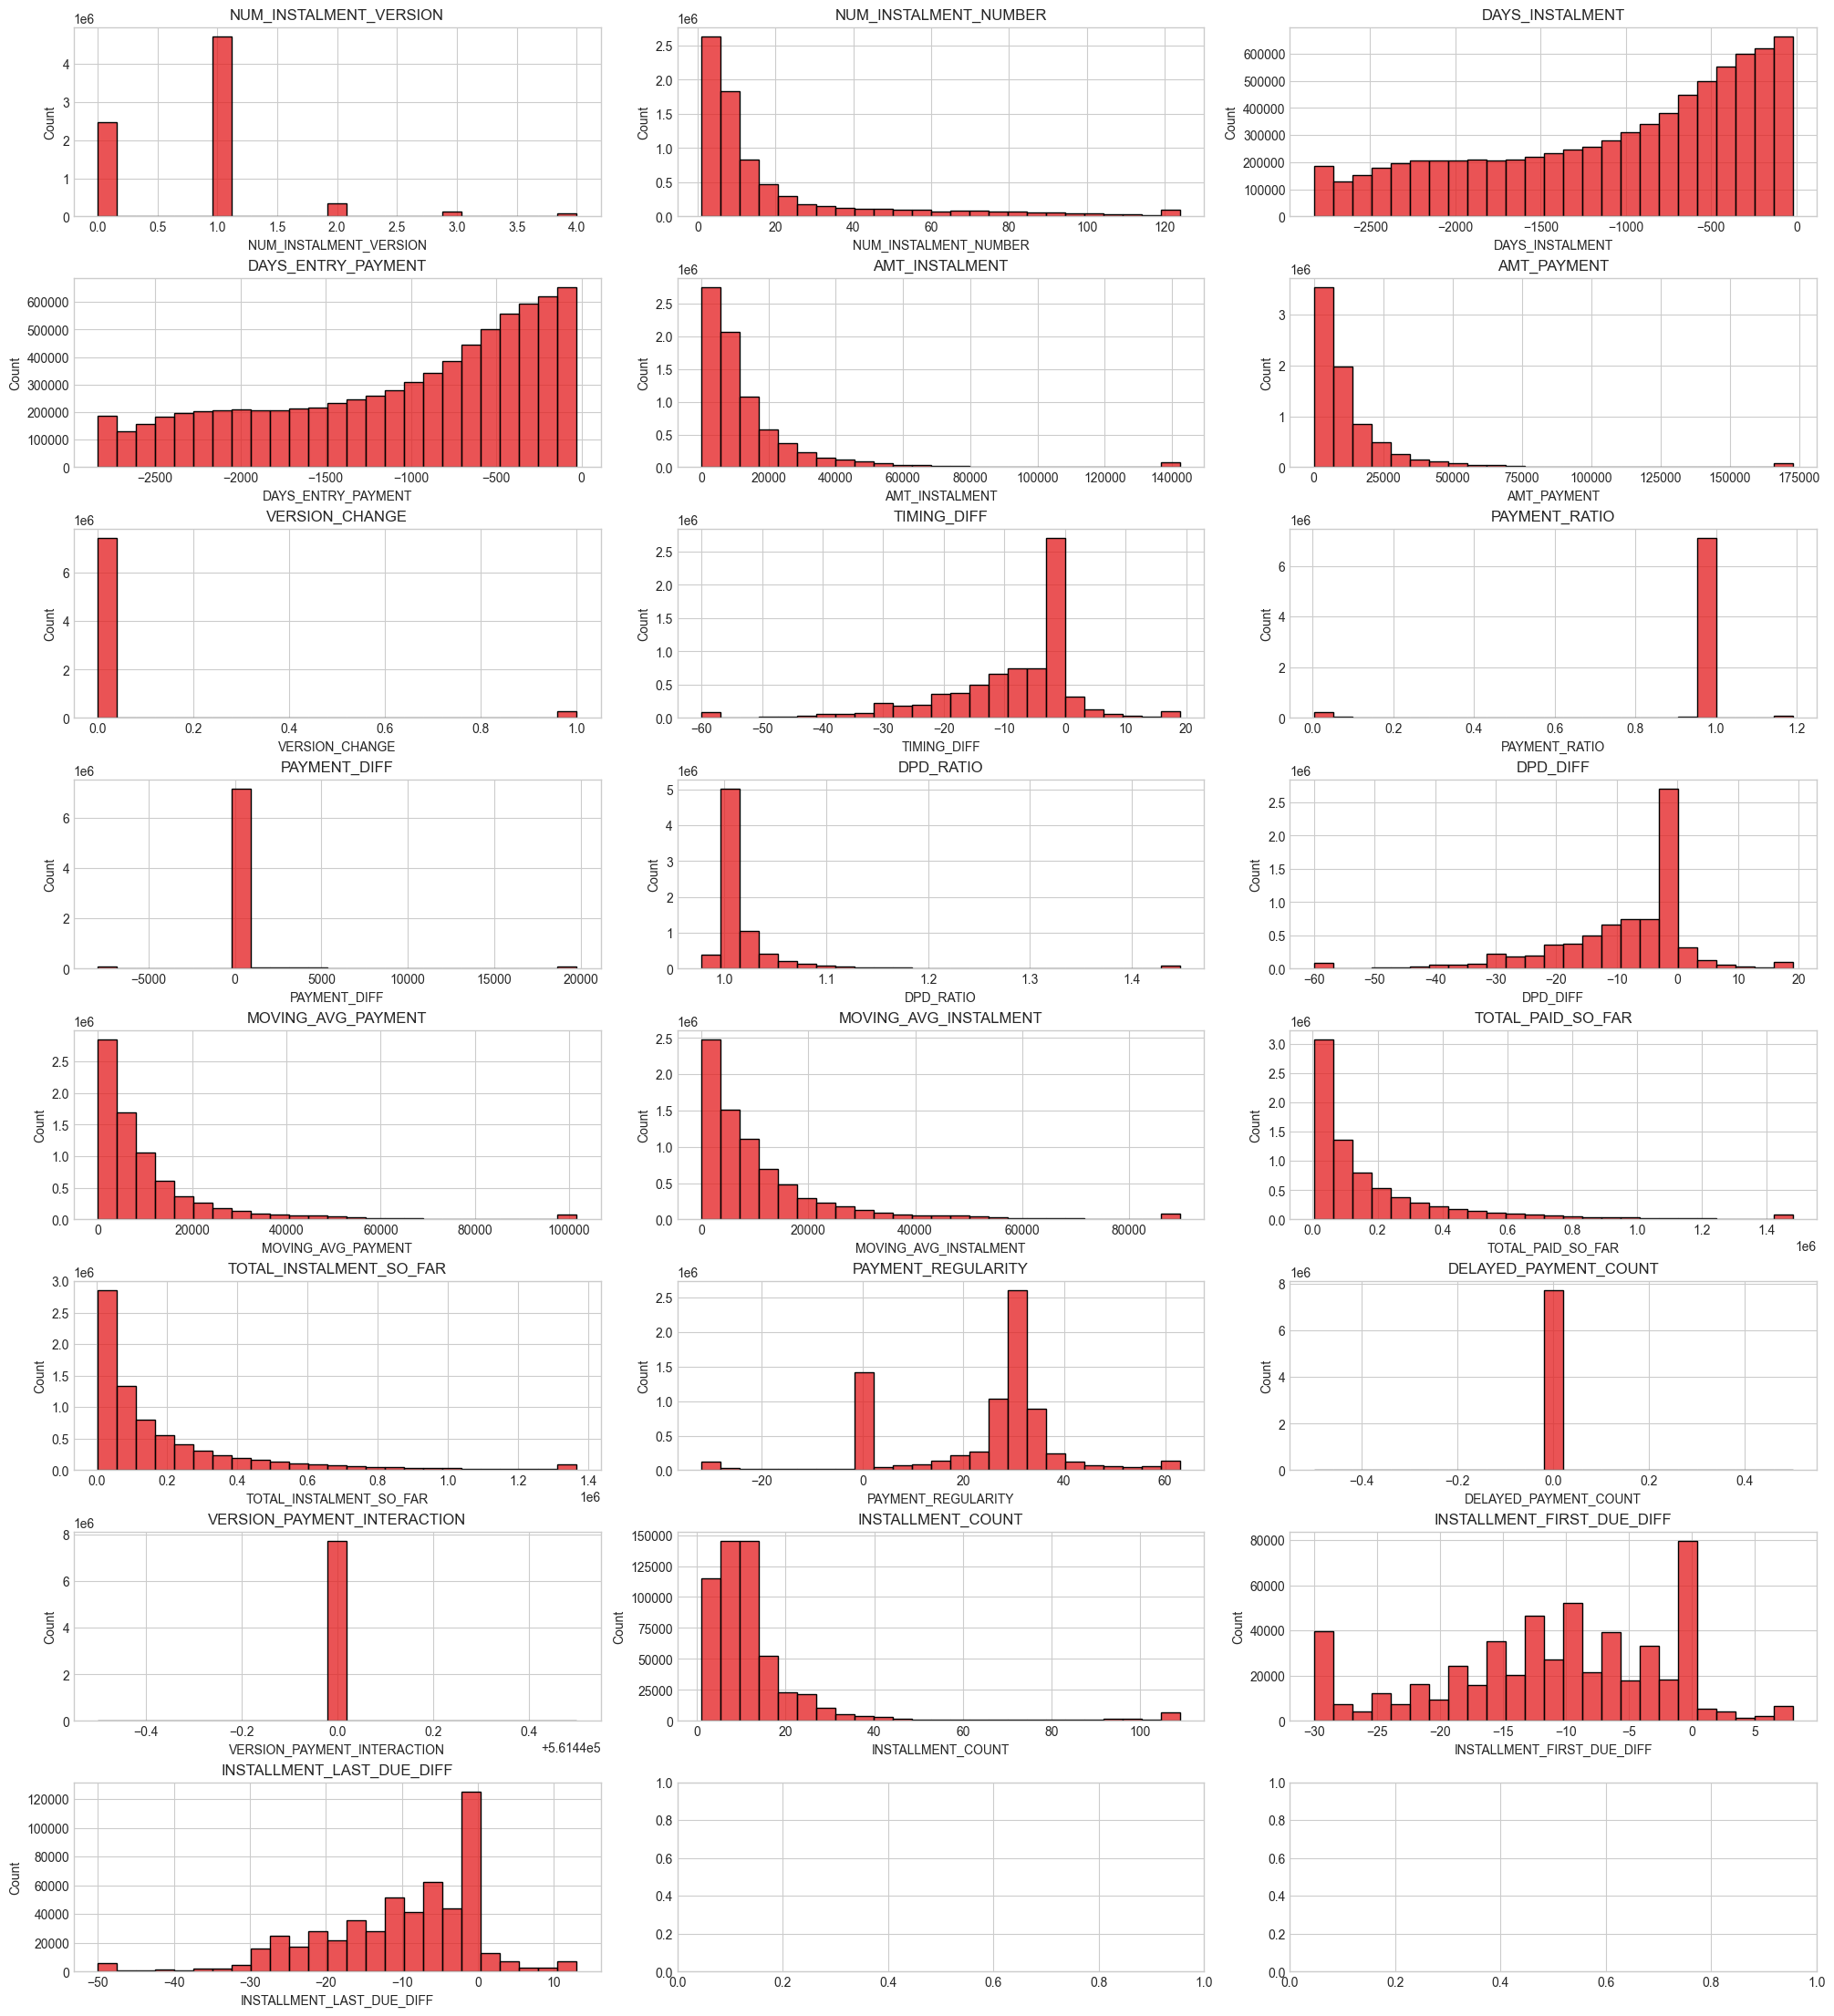

In [12]:
# Plot histogram of numerical columns
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.histplot(x=df[column], ax=ax, bins=25)
    ax.set_title(column)

plt.show()

## Correlation

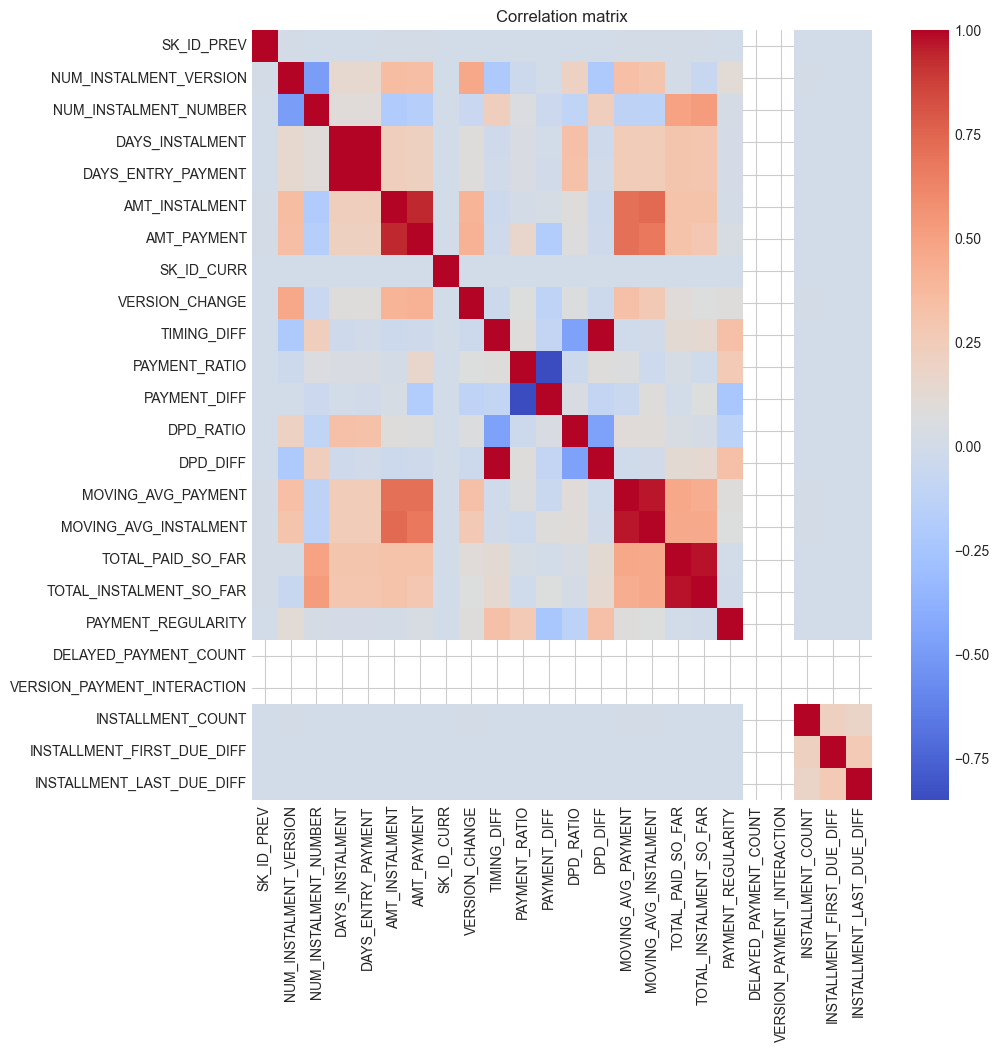

In [13]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
num_cols = df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(df[num_cols].corr(), ax=ax,cmap='coolwarm')
ax.set_title('Correlation matrix')
plt.show()

# Merge with TARGET

In [14]:
# Merge with target
df = df.merge(target, on='SK_ID_CURR', how='left')
df.head()

SK_ID_PREV  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
0     1000001                     1.0                      1           -268.0   
1     1000001                     2.0                      2           -238.0   
2     1000003                     1.0                      1            -94.0   
3     1000003                     1.0                      2            -64.0   
4     1000003                     1.0                      3            -34.0   

   DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  SK_ID_CURR  \
0              -294.0        6404.310     6404.310    117953.0   
1              -244.0       62039.115    62039.115    117953.0   
2              -108.0        4951.350     4951.350      6707.0   
3               -81.0        4951.350     4951.350      6707.0   
4               -49.0        4951.350     4951.350      6707.0   

   VERSION_CHANGE  TIMING_DIFF  ...  MOVING_AVG_INSTALMENT  TOTAL_PAID_SO_FAR  \
0             0.0        -26.0  ...                   0.00           6404.310   
1             1.0         -6.0  ...                   0.00          68443.425   
2             0.0        -14.0  ...                   0.00           4951.350   
3             0.0        -17.0  ...                   0.00           9902.700   
4             0.0        -15.0  ...                4951.35          14854.050   

   TOTAL_INSTALMENT_SO_FAR  PAYMENT_REGULARITY  DELAYED_PAYMENT_COUNT  \
0                 6404.310                 0.0                      0   
1                68443.425                50.0                      0   
2                 4951.350                 0.0                      0   
3                 9902.700                27.0                      0   
4                14854.050                32.0                      0   

   VERSION_PAYMENT_INTERACTION  INSTALLMENT_COUNT  INSTALLMENT_FIRST_DUE_DIFF  \
0                       561440                NaN                         NaN   
1                       561440                NaN                         NaN   
2                       561440                NaN                         NaN   
3                       561440                NaN                         NaN   
4                       561440                NaN                         NaN   

   INSTALLMENT_LAST_DUE_DIFF  TARGET  
0                        NaN     0.0  
1                        NaN     0.0  
2                        NaN     0.0  
3                        NaN     0.0  
4                        NaN     0.0  

[5 rows x 26 columns]

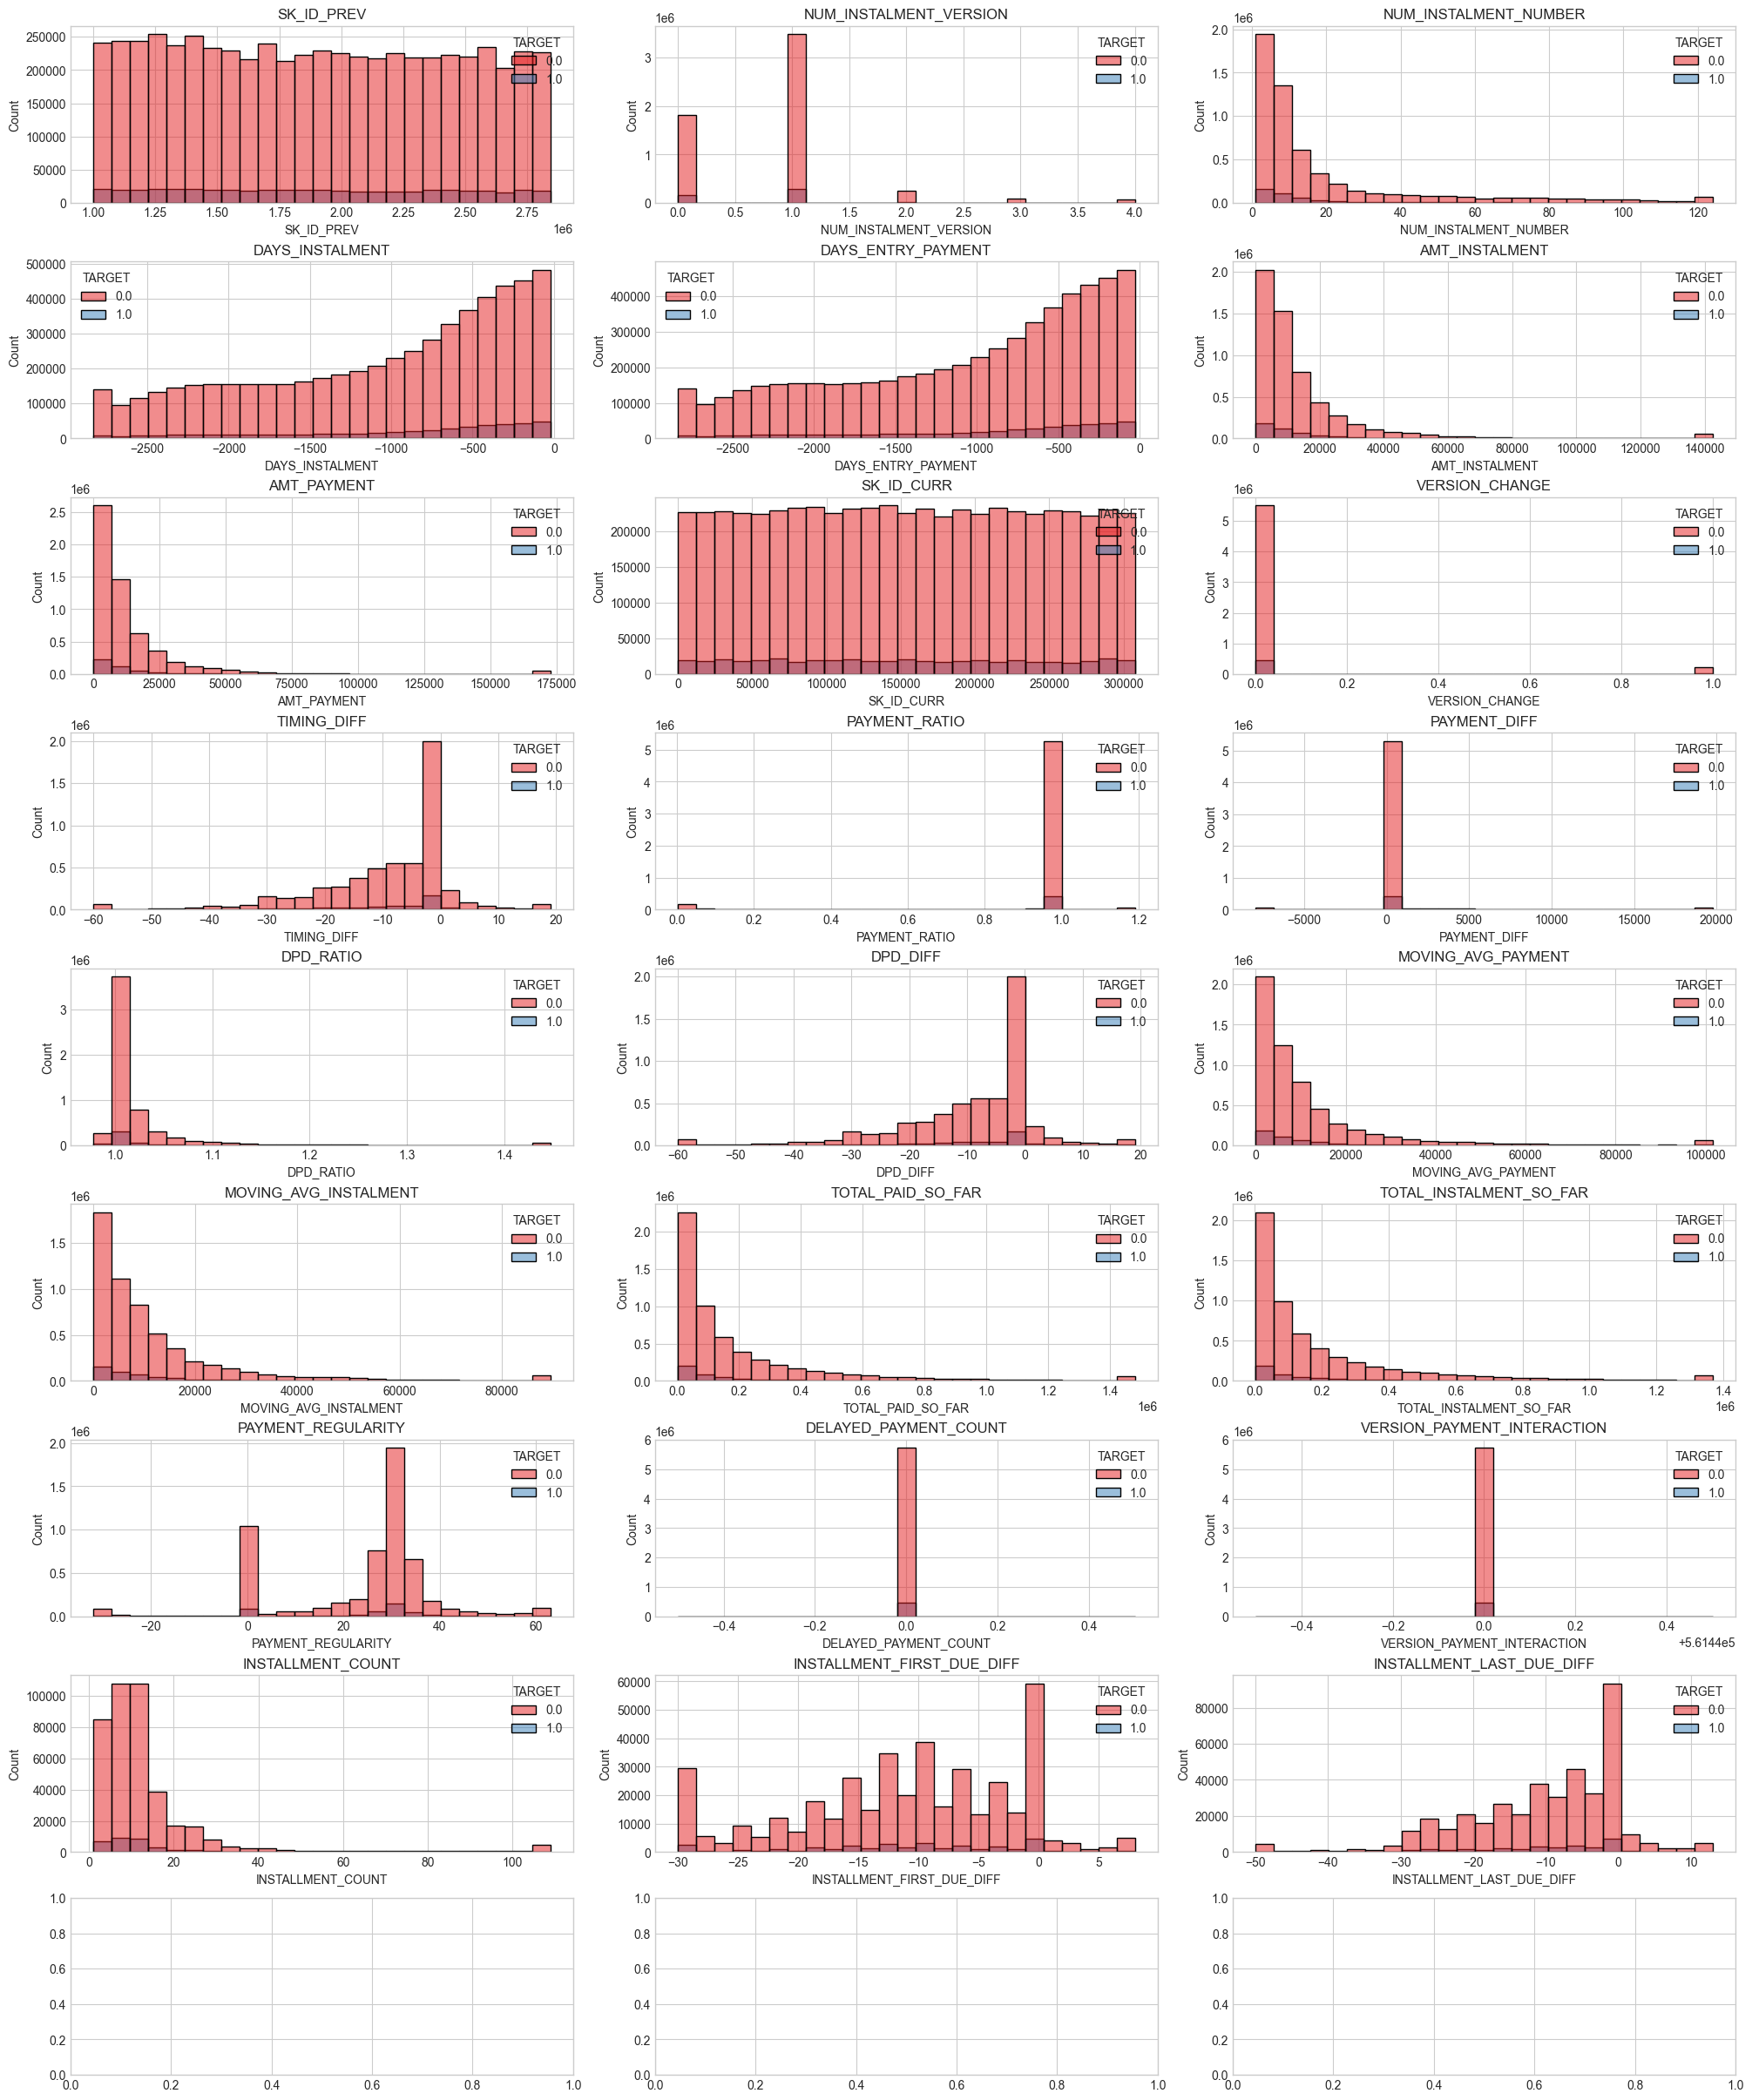

In [15]:
# Plot histogram of numerical columns with hue of target
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.histplot(x=df[column], ax=ax, bins=25, hue='TARGET', data=df, palette='Set1')
    ax.set_title(column)

plt.show()

# Group by SK_ID_CURR

In [16]:
df = df_copy.copy()
df = create_features(df)
df.drop(columns=['SK_ID_PREV'], inplace=True)

# Groupby SK_ID_PREV
grouped = df.groupby('SK_ID_CURR')

In [17]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('SK_ID_CURR')
num_cols

['NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'VERSION_CHANGE',
 'TIMING_DIFF',
 'PAYMENT_RATIO',
 'PAYMENT_DIFF',
 'DPD_RATIO',
 'DPD_DIFF',
 'MOVING_AVG_PAYMENT',
 'MOVING_AVG_INSTALMENT',
 'TOTAL_PAID_SO_FAR',
 'TOTAL_INSTALMENT_SO_FAR',
 'PAYMENT_REGULARITY',
 'DELAYED_PAYMENT_COUNT',
 'VERSION_PAYMENT_INTERACTION',
 'INSTALLMENT_COUNT',
 'INSTALLMENT_FIRST_DUE_DIFF',
 'INSTALLMENT_LAST_DUE_DIFF']

## Mean

In [18]:
mean_df = grouped.mean()
mean_df = mean_df.merge(target, on='SK_ID_CURR', how='left')
mean_df

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0              0.0                0.433333               7.866667   
1              1.0                0.700000               6.100000   
2              3.0                0.418605              12.209302   
3              4.0                1.000000               3.500000   
4              5.0                1.000000               5.500000   
...            ...                     ...                    ...   
180728    307501.0                1.272727               5.000000   
180729    307503.0                1.000000               5.500000   
180730    307504.0                0.127820              60.120301   
180731    307506.0                1.000000               6.071429   
180732    307508.0                1.000000               6.211538   

        DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  \
0           -139.533333         -150.433333    10364.746500  10364.746500   
1           -620.125000         -622.050000    23583.619125  19684.164375   
2           -216.651163         -228.232558     5691.316395   5895.386163   
3          -2282.000000        -2299.166667     8953.522500   8953.522500   
4          -1935.000000        -1944.200000     9818.644500   9818.644500   
...                 ...                 ...             ...           ...   
180728     -1384.636364        -1395.000000     9446.938636   9446.938636   
180729     -2138.000000        -2149.300000     4494.393000   4494.393000   
180730     -1661.052632        -1664.165414     1819.209586   1641.799286   
180731      -764.857143         -772.214286    12342.222857  12342.222857   
180732     -1061.634615        -1074.673077    20946.439038  18013.916250   

        VERSION_CHANGE  TIMING_DIFF  PAYMENT_RATIO  ...  \
0             0.100000   -10.900000       1.000000  ...   
1             0.025000    -1.925000       0.850000  ...   
2             0.093023   -11.581395       1.050525  ...   
3             0.000000   -17.166667       1.000000  ...   
4             0.000000    -9.200000       1.000000  ...   
...                ...          ...            ...  ...   
180728        0.060606   -10.363636       1.000000  ...   
180729        0.000000   -11.300000       1.000000  ...   
180730        0.000000    -3.112782       0.962406  ...   
180731        0.000000    -7.357143       1.000000  ...   
180732        0.000000   -13.038462       0.826923  ...   

        MOVING_AVG_INSTALMENT  TOTAL_PAID_SO_FAR  TOTAL_INSTALMENT_SO_FAR  \
0                 5548.296500       44707.321500             44707.321500   
1                15925.851000       92882.109375            131182.395750   
2                 3533.841279       50741.490349             50252.067209   
3                 5970.317500       31347.097500             31347.097500   
4                 7855.900500       54012.042000             54012.042000   
...                       ...                ...                      ...   
180728            6654.043182       41580.008182             41580.008182   
180729            3596.388000       24727.585500             24727.585500   
180730            1564.847932      100640.207707            111356.649135   
180731           10217.484286       78995.795357             78995.795357   
180732           17582.726827      126276.621923            150168.059135   

        PAYMENT_REGULARITY  DELAYED_PAYMENT_COUNT  \
0                15.233333                    0.0   
1                18.650000                    0.0   
2                13.674419                    0.0   
3                24.000000                    0.0   
4                27.500000                    0.0   
...                    ...                    ...   
180728           25.393939                    0.0   
180729           27.500000                    0.0   
180730           23.601504                    0.0   
180731           27.714286                    0.0   
180732           22.480769           

In [19]:
# Clip outliers
for column in num_cols:
    mean_df[column] = mean_df[column].clip(mean_df[column].quantile(0.01), mean_df[column].quantile(0.99))

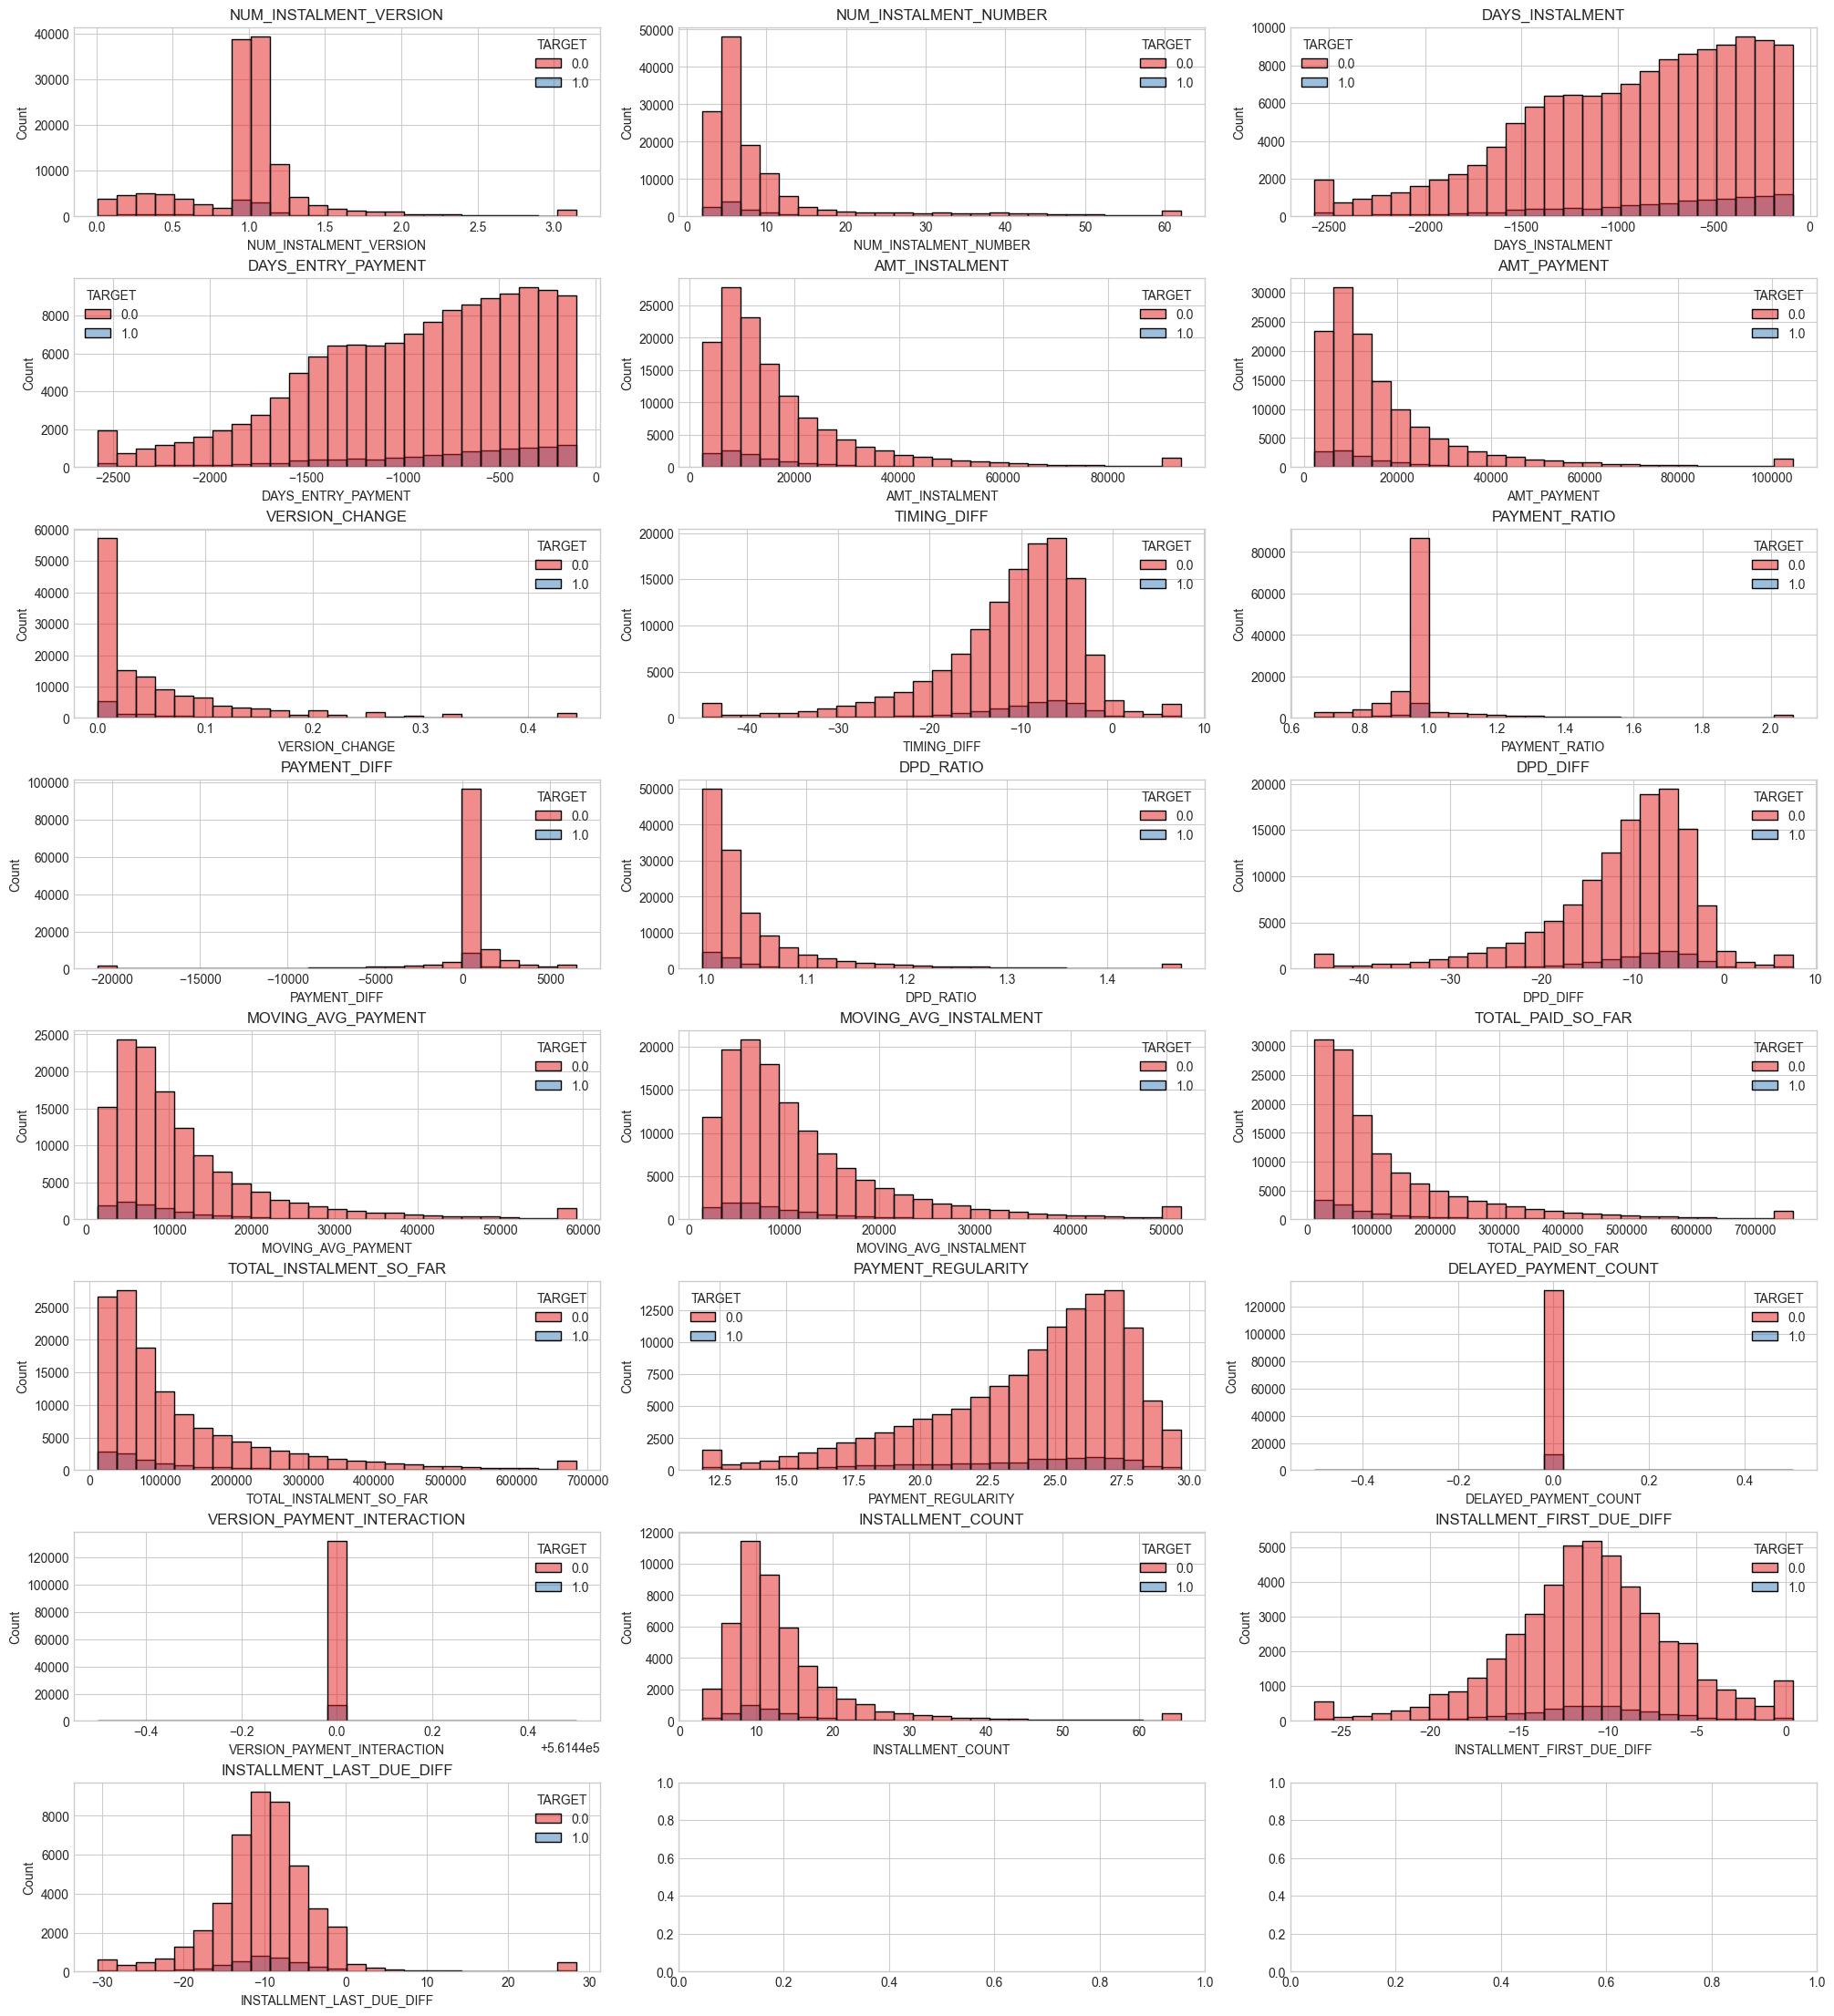

In [20]:
# Plot histogram of numerical columns with hue of target
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.histplot(x=mean_df[column], ax=ax, bins=25, hue='TARGET', data=mean_df, palette='Set1')
    ax.set_title(column)

plt.show()

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/3704405666.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=mean_df[column], ax=ax, hue='TARGET', data=mean_df, palette='Set1')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/3704405666.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=mean_df[column], ax=ax, hue='TARGET', data=mean_df, palette='Set1')


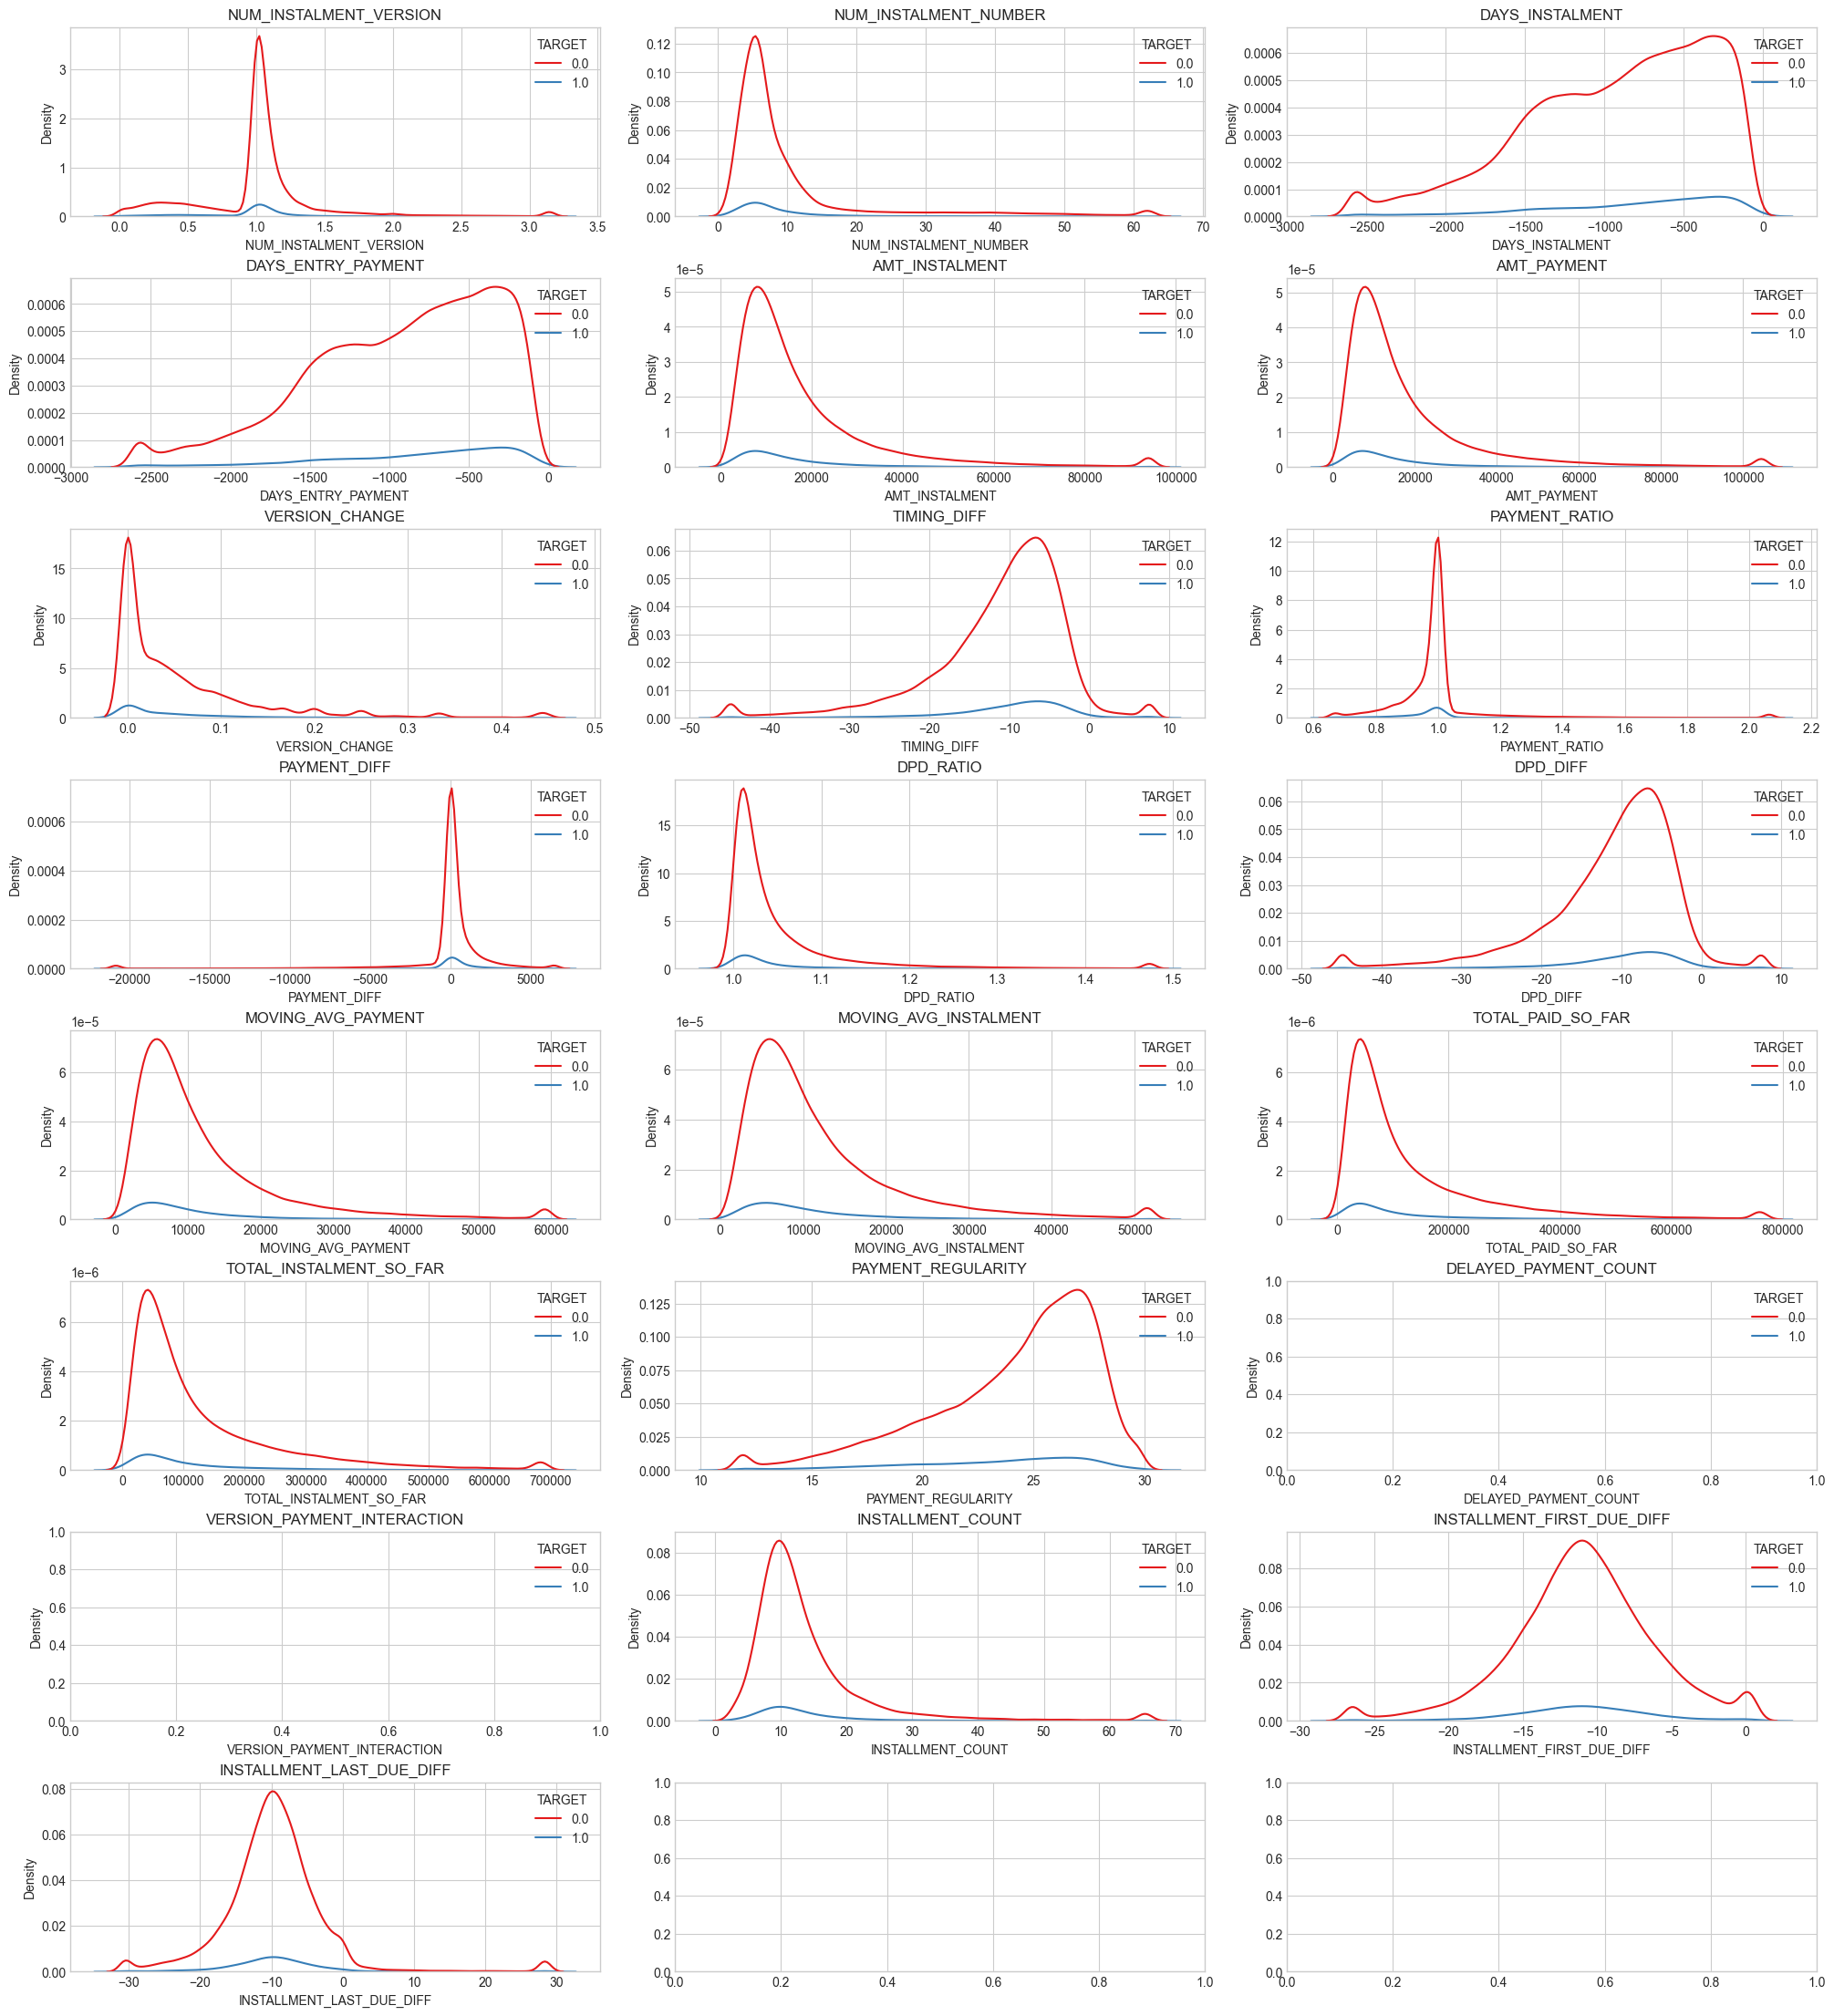

In [21]:
# Plot histogram of numerical columns with hue of target
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.kdeplot(x=mean_df[column], ax=ax, hue='TARGET', data=mean_df, palette='Set1')
    ax.set_title(column)

plt.show()

## Max

In [22]:
# Inspect max values
max_df = grouped.max()
max_df = max_df.merge(target, on='SK_ID_CURR', how='left')

# Clip outliers
for column in num_cols:
    max_df[column] = max_df[column].clip(max_df[column].quantile(0.01), max_df[column].quantile(0.99))

max_df

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0              0.0                     2.0                     21   
1              1.0                     2.0                     13   
2              3.0                     4.0                     31   
3              4.0                     1.0                      6   
4              5.0                     1.0                     10   
...            ...                     ...                    ...   
180728    307501.0                     3.0                     12   
180729    307503.0                     1.0                     10   
180730    307504.0                     3.0                    123   
180731    307506.0                     1.0                     12   
180732    307508.0                     1.0                     12   

        DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  \
0                  -5.0                -5.0      100287.765   100287.765   
1                 -18.0               -18.0      361186.425   361186.425   
2                  -5.0                -5.0       43050.285    43050.285   
3               -2207.0             -2230.0        8957.430     8957.430   
4               -1800.0             -1808.0        9820.755     9820.755   
...                 ...                 ...             ...          ...   
180728           -494.0              -503.0       50197.005    50197.005   
180729          -2003.0             -2013.0        4496.265     4496.265   
180730            -10.0               -22.0       18135.000    18135.000   
180731            -53.0               -66.0       17043.120    17043.120   
180732             -6.0               -25.0       44095.590    44095.590   

        VERSION_CHANGE  TIMING_DIFF  PAYMENT_RATIO  ...  \
0                  1.0          0.0        1.00000  ...   
1                  1.0         29.0        1.00000  ...   
2                  3.0          0.0        2.51059  ...   
3                  0.0        -14.0        1.00000  ...   
4                  0.0         -6.0        1.00000  ...   
...                ...          ...            ...  ...   
180728             1.0          0.0        1.00000  ...   
180729             0.0         -8.0        1.00000  ...   
180730             2.0         55.0        1.00000  ...   
180731             0.0         14.0        1.00000  ...   
180732             0.0         12.0        1.00000  ...   

        MOVING_AVG_INSTALMENT  TOTAL_PAID_SO_FAR  TOTAL_INSTALMENT_SO_FAR  \
0                   40878.975         122636.925               122636.925   
1                  137726.385         621150.075               777128.265   
2                   18273.855         107919.720               107919.720   
3                    8957.430          53721.135                53721.135   
4                    9820.755          98186.445                98186.445   
...                       ...                ...                      ...   
180728              25672.305         157607.145               157607.145   
180729               4496.265          44943.930                44943.930   
180730               8745.000         143740.080               159940.080   
180731              17043.120         204447.330               204447.330   
180732              44095.590         440750.610               484846.200   

        PAYMENT_REGULARITY  DELAYED_PAYMENT_COUNT  \
0                     91.0                      0   
1                     38.0                      0   
2                    128.0                      0   
3                     34.0                      0   
4                     35.0                      0   
...                    ...                    ...   
180728                60.0                      0   
180729                34.0                      0   
180730                92.0                      0   
180731                43.0                      0   
180732                73.0                      0

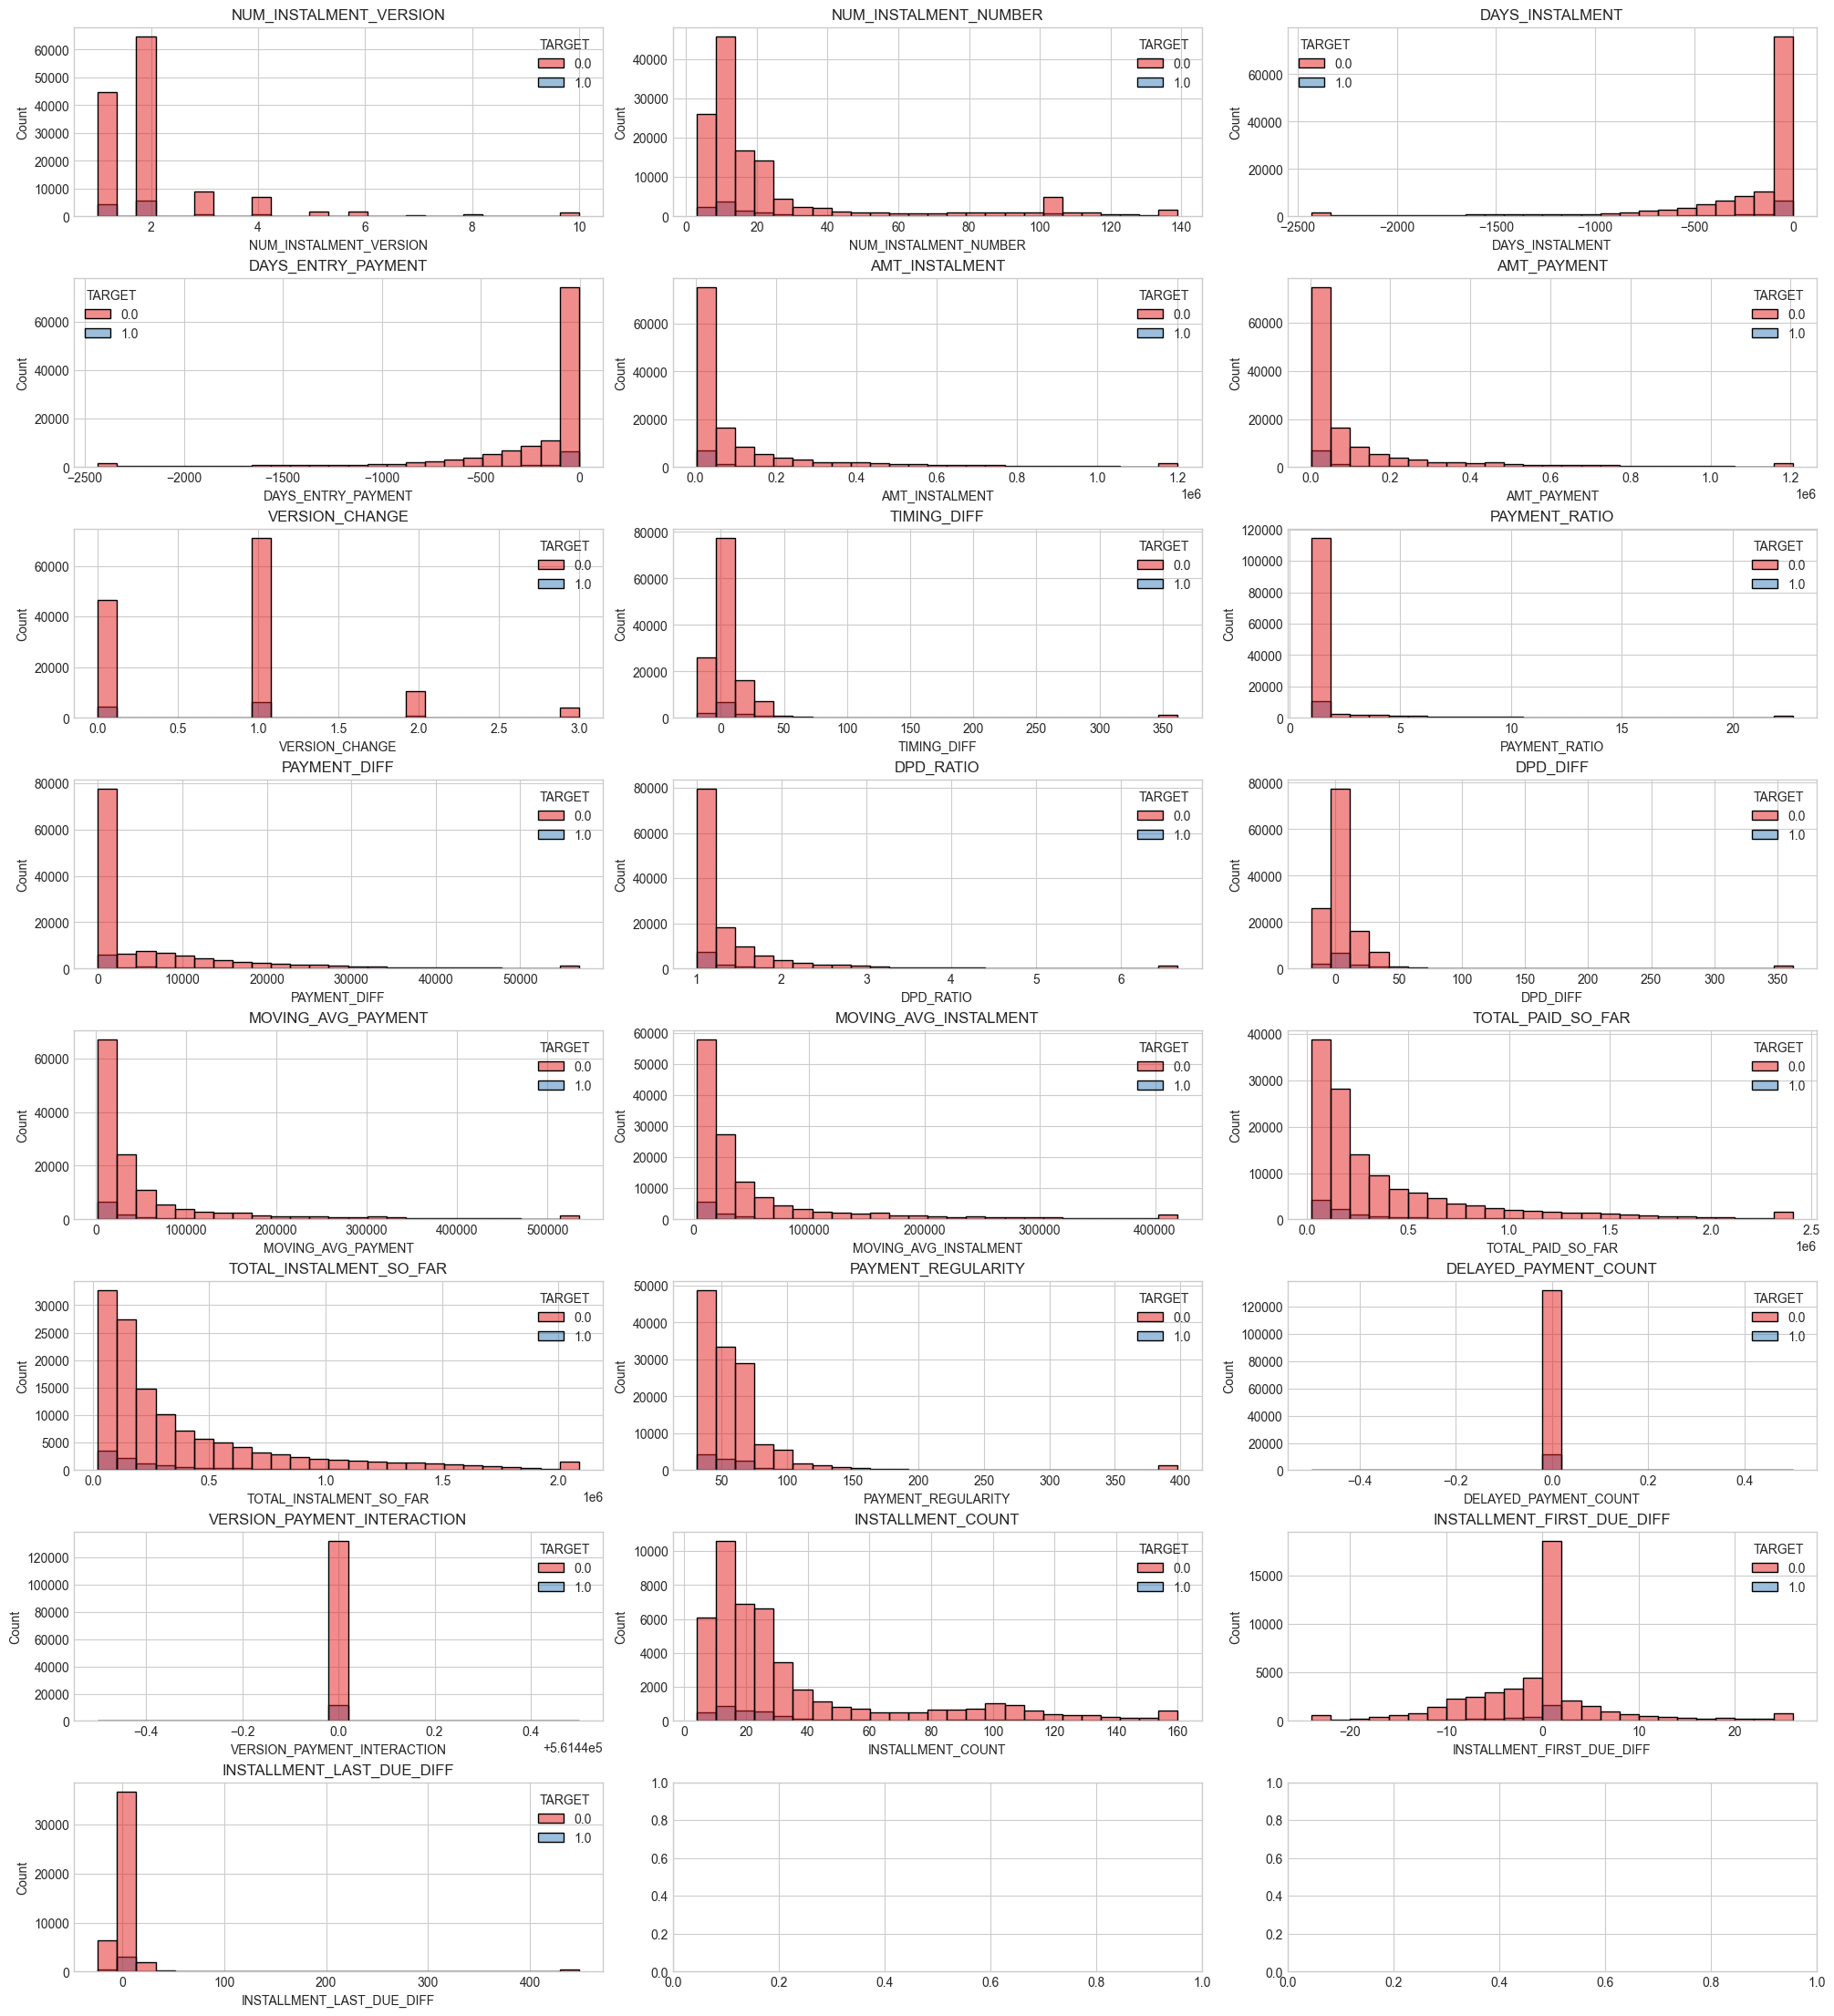

In [23]:
# Plot distribution of max values
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.histplot(x=max_df[column], ax=ax, bins=25, hue='TARGET', data=max_df, palette='Set1')
    ax.set_title(column)

plt.show()

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/3904289556.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=max_df[column], ax=ax, hue='TARGET', data=max_df, palette='Set1')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/3904289556.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=max_df[column], ax=ax, hue='TARGET', data=max_df, palette='Set1')


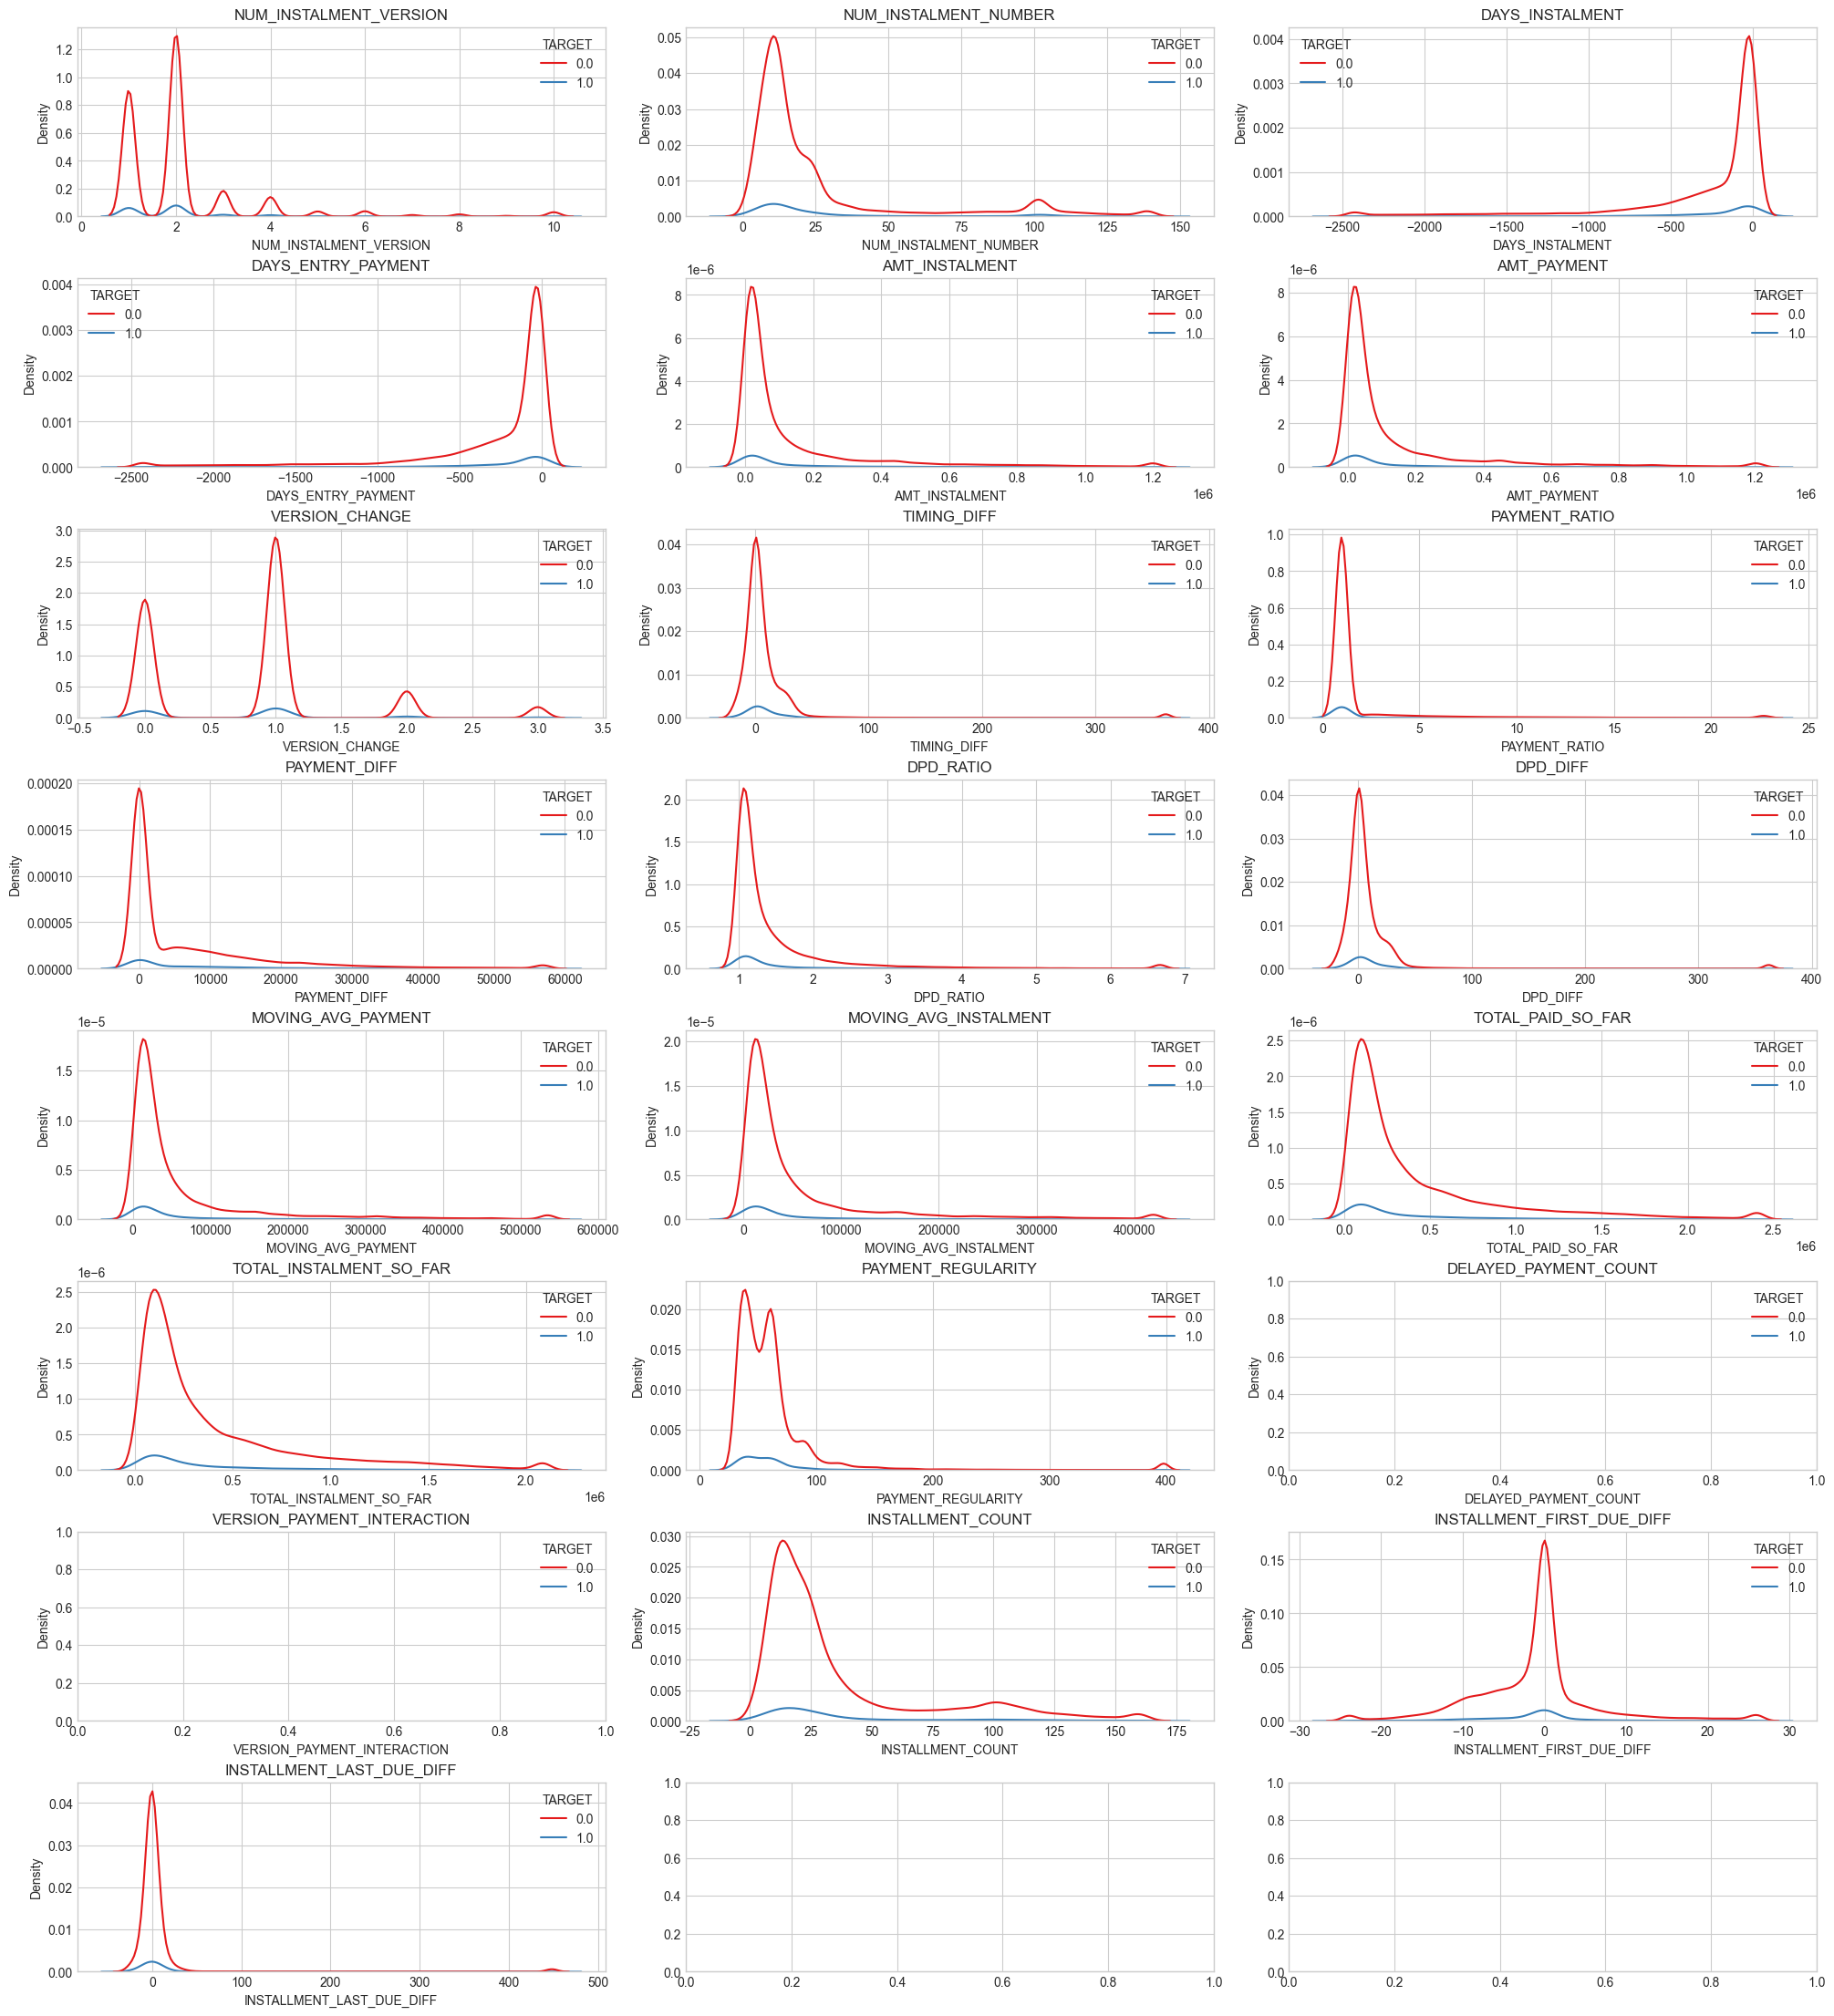

In [24]:
# Plot kde of max values
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.kdeplot(x=max_df[column], ax=ax, hue='TARGET', data=max_df, palette='Set1')
    ax.set_title(column)

plt.show()

## Var

In [25]:
# Inspect variance
var_df = grouped.var()
var_df = var_df.merge(target, on='SK_ID_CURR', how='left')

# Clip outliers
for column in num_cols:
    var_df[column] = var_df[column].clip(var_df[column].quantile(0.01), var_df[column].quantile(0.99))

var_df

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0              0.0                0.460920              40.257471   
1              1.0                0.266667              11.425641   
2              3.0                0.677741              97.550388   
3              4.0                0.000000               3.500000   
4              5.0                0.000000               9.166667   
...            ...                     ...                    ...   
180728    307501.0                0.267045               9.125000   
180729    307503.0                0.000000               9.166667   
180730    307504.0                0.172932            1317.106630   
180731    307506.0                0.000000              12.019164   
180732    307508.0                0.000000              10.875943   

        DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  \
0          14311.774713        17601.150575    4.113659e+08  4.113659e+08   
1         276716.676282       276637.792308    3.095012e+09  3.158596e+09   
2          26340.851606        28596.706534    6.766554e+07  6.795686e+07   
3           3150.000000         3010.166667    9.161134e+01  9.161134e+01   
4           8250.000000         8729.733333    4.454210e+01  4.454210e+01   
...                 ...                 ...             ...           ...   
180728    411642.801136       415935.875000    6.464310e+07  6.464310e+07   
180729      8250.000000         8498.455556    3.504384e+01  3.504384e+01   
180730    792999.095694       793308.305764    7.077860e+06  6.412420e+06   
180731    487246.222997       479615.294425    2.066243e+07  2.066243e+07   
180732    706175.059955       694592.930241    1.639886e+08  1.957182e+08   

        VERSION_CHANGE  TIMING_DIFF  PAYMENT_RATIO  ...  \
0             0.093103   374.575862       0.000000  ...   
1             0.025000   130.532692       0.122642  ...   
2             0.276855   459.439646       0.062151  ...   
3             0.000000    10.166667       0.000000  ...   
4             0.000000    13.066667       0.000000  ...   
...                ...          ...            ...  ...   
180728        0.058712    62.988636       0.000000  ...   
180729        0.000000     5.122222       0.000000  ...   
180730        0.075758   170.494760       0.022569  ...   
180731        0.000000    52.479094       0.000000  ...   
180732        0.000000   201.135747       0.128801  ...   

        MOVING_AVG_INSTALMENT  TOTAL_PAID_SO_FAR  TOTAL_INSTALMENT_SO_FAR  \
0                7.934810e+07       1.584805e+09             1.584805e+09   
1                4.987252e+08       1.236857e+10             2.521167e+10   
2                1.183465e+07       1.081816e+09             1.110233e+09   
3                2.138682e+07       2.806145e+08             2.806145e+08   
4                1.714311e+07       8.838924e+08             8.838924e+08   
...                       ...                ...                      ...   
180728           3.237362e+07       1.053794e+09             1.053794e+09   
180729           3.592783e+06       1.852329e+08             1.852329e+08   
180730           4.436416e+06       2.409259e+09             3.146646e+09   
180731           4.014916e+07       3.134520e+09             3.134520e+09   
180732           1.921915e+08       9.952226e+09             1.286586e+10   

        PAYMENT_REGULARITY  DELAYED_PAYMENT_COUNT  \
0               366.116092                    0.0   
1               314.900000                    0.0   
2               504.129568                    0.0   
3               150.400000                    0.0   
4               101.388889                    0.0   
...                    ...                    ...   
180728          198.808712                    0.0   
180729           99.166667                    0.0   
180730          343.786967                    0.0   
180731           96.599303                    0.0   
180732          638.999623           

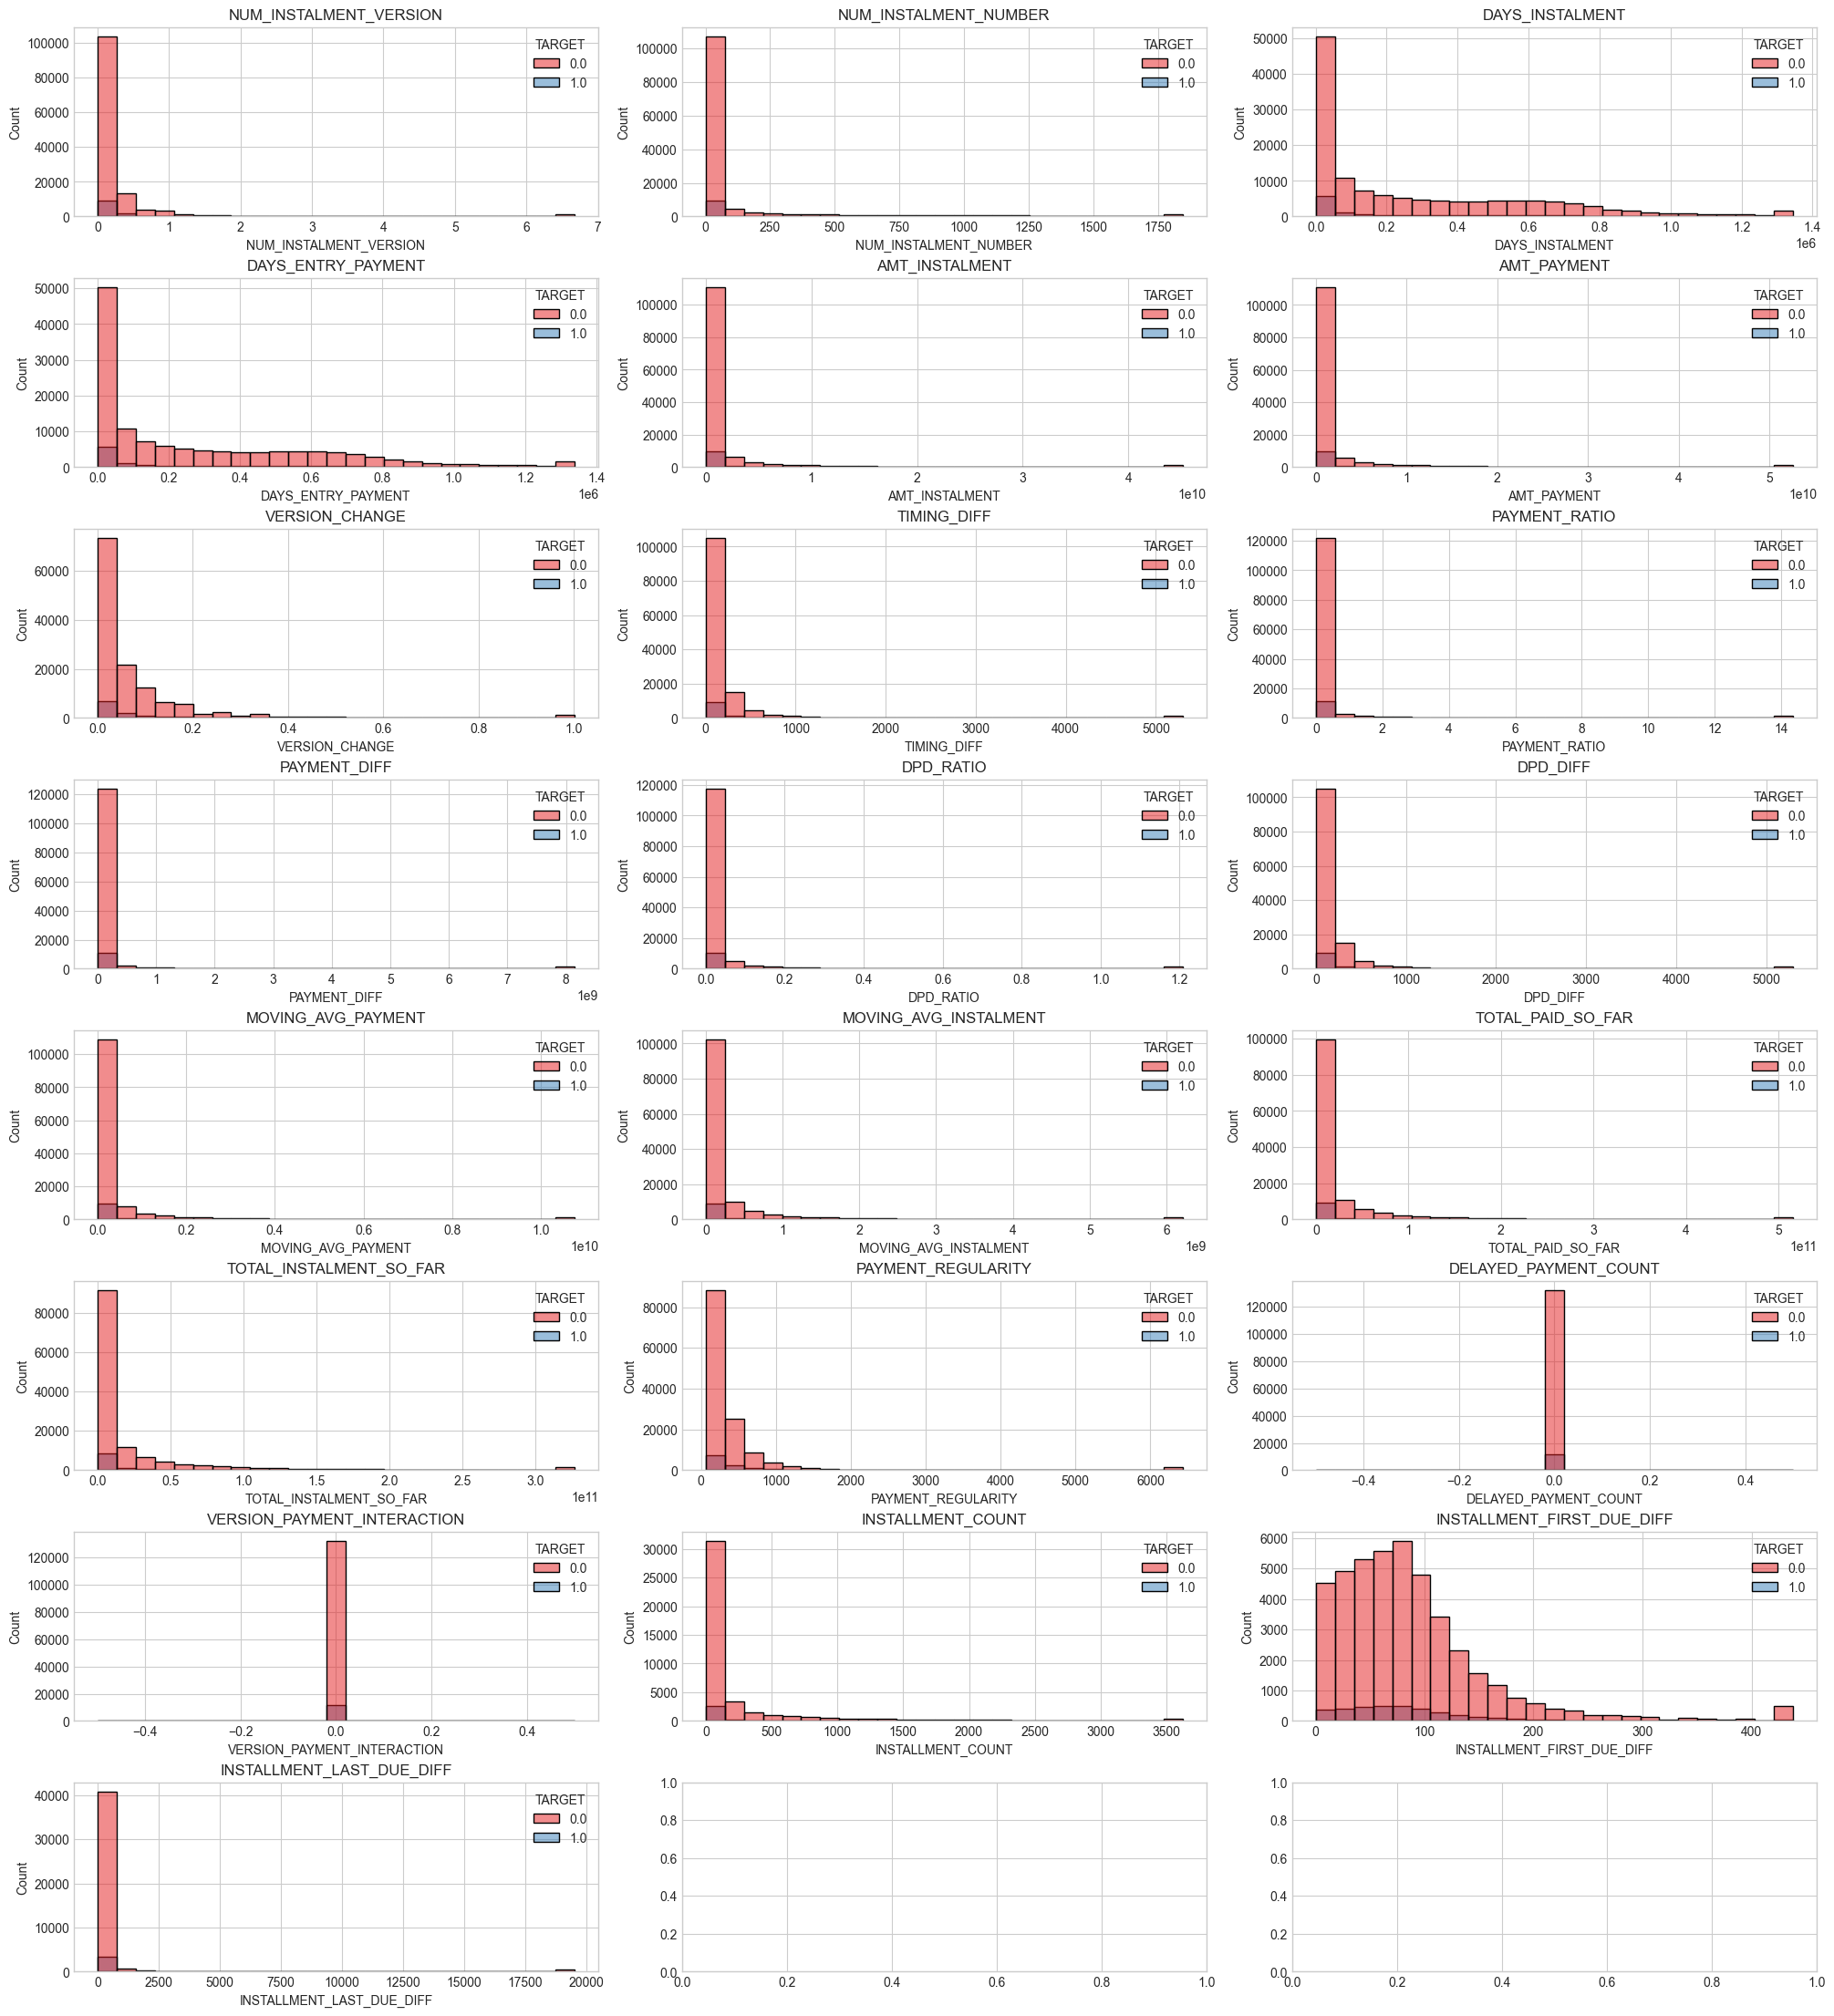

In [26]:
# Plot distribution of variance
ncol, nrow = 3, len(num_cols)//3 + 1

fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.histplot(x=var_df[column], ax=ax, bins=25, hue='TARGET', data=var_df, palette='Set1')
    ax.set_title(column)

plt.show()

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/1136396129.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=var_df[column], ax=ax, hue='TARGET', data=var_df, palette='Set1')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_93502/1136396129.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=var_df[column], ax=ax, hue='TARGET', data=var_df, palette='Set1')


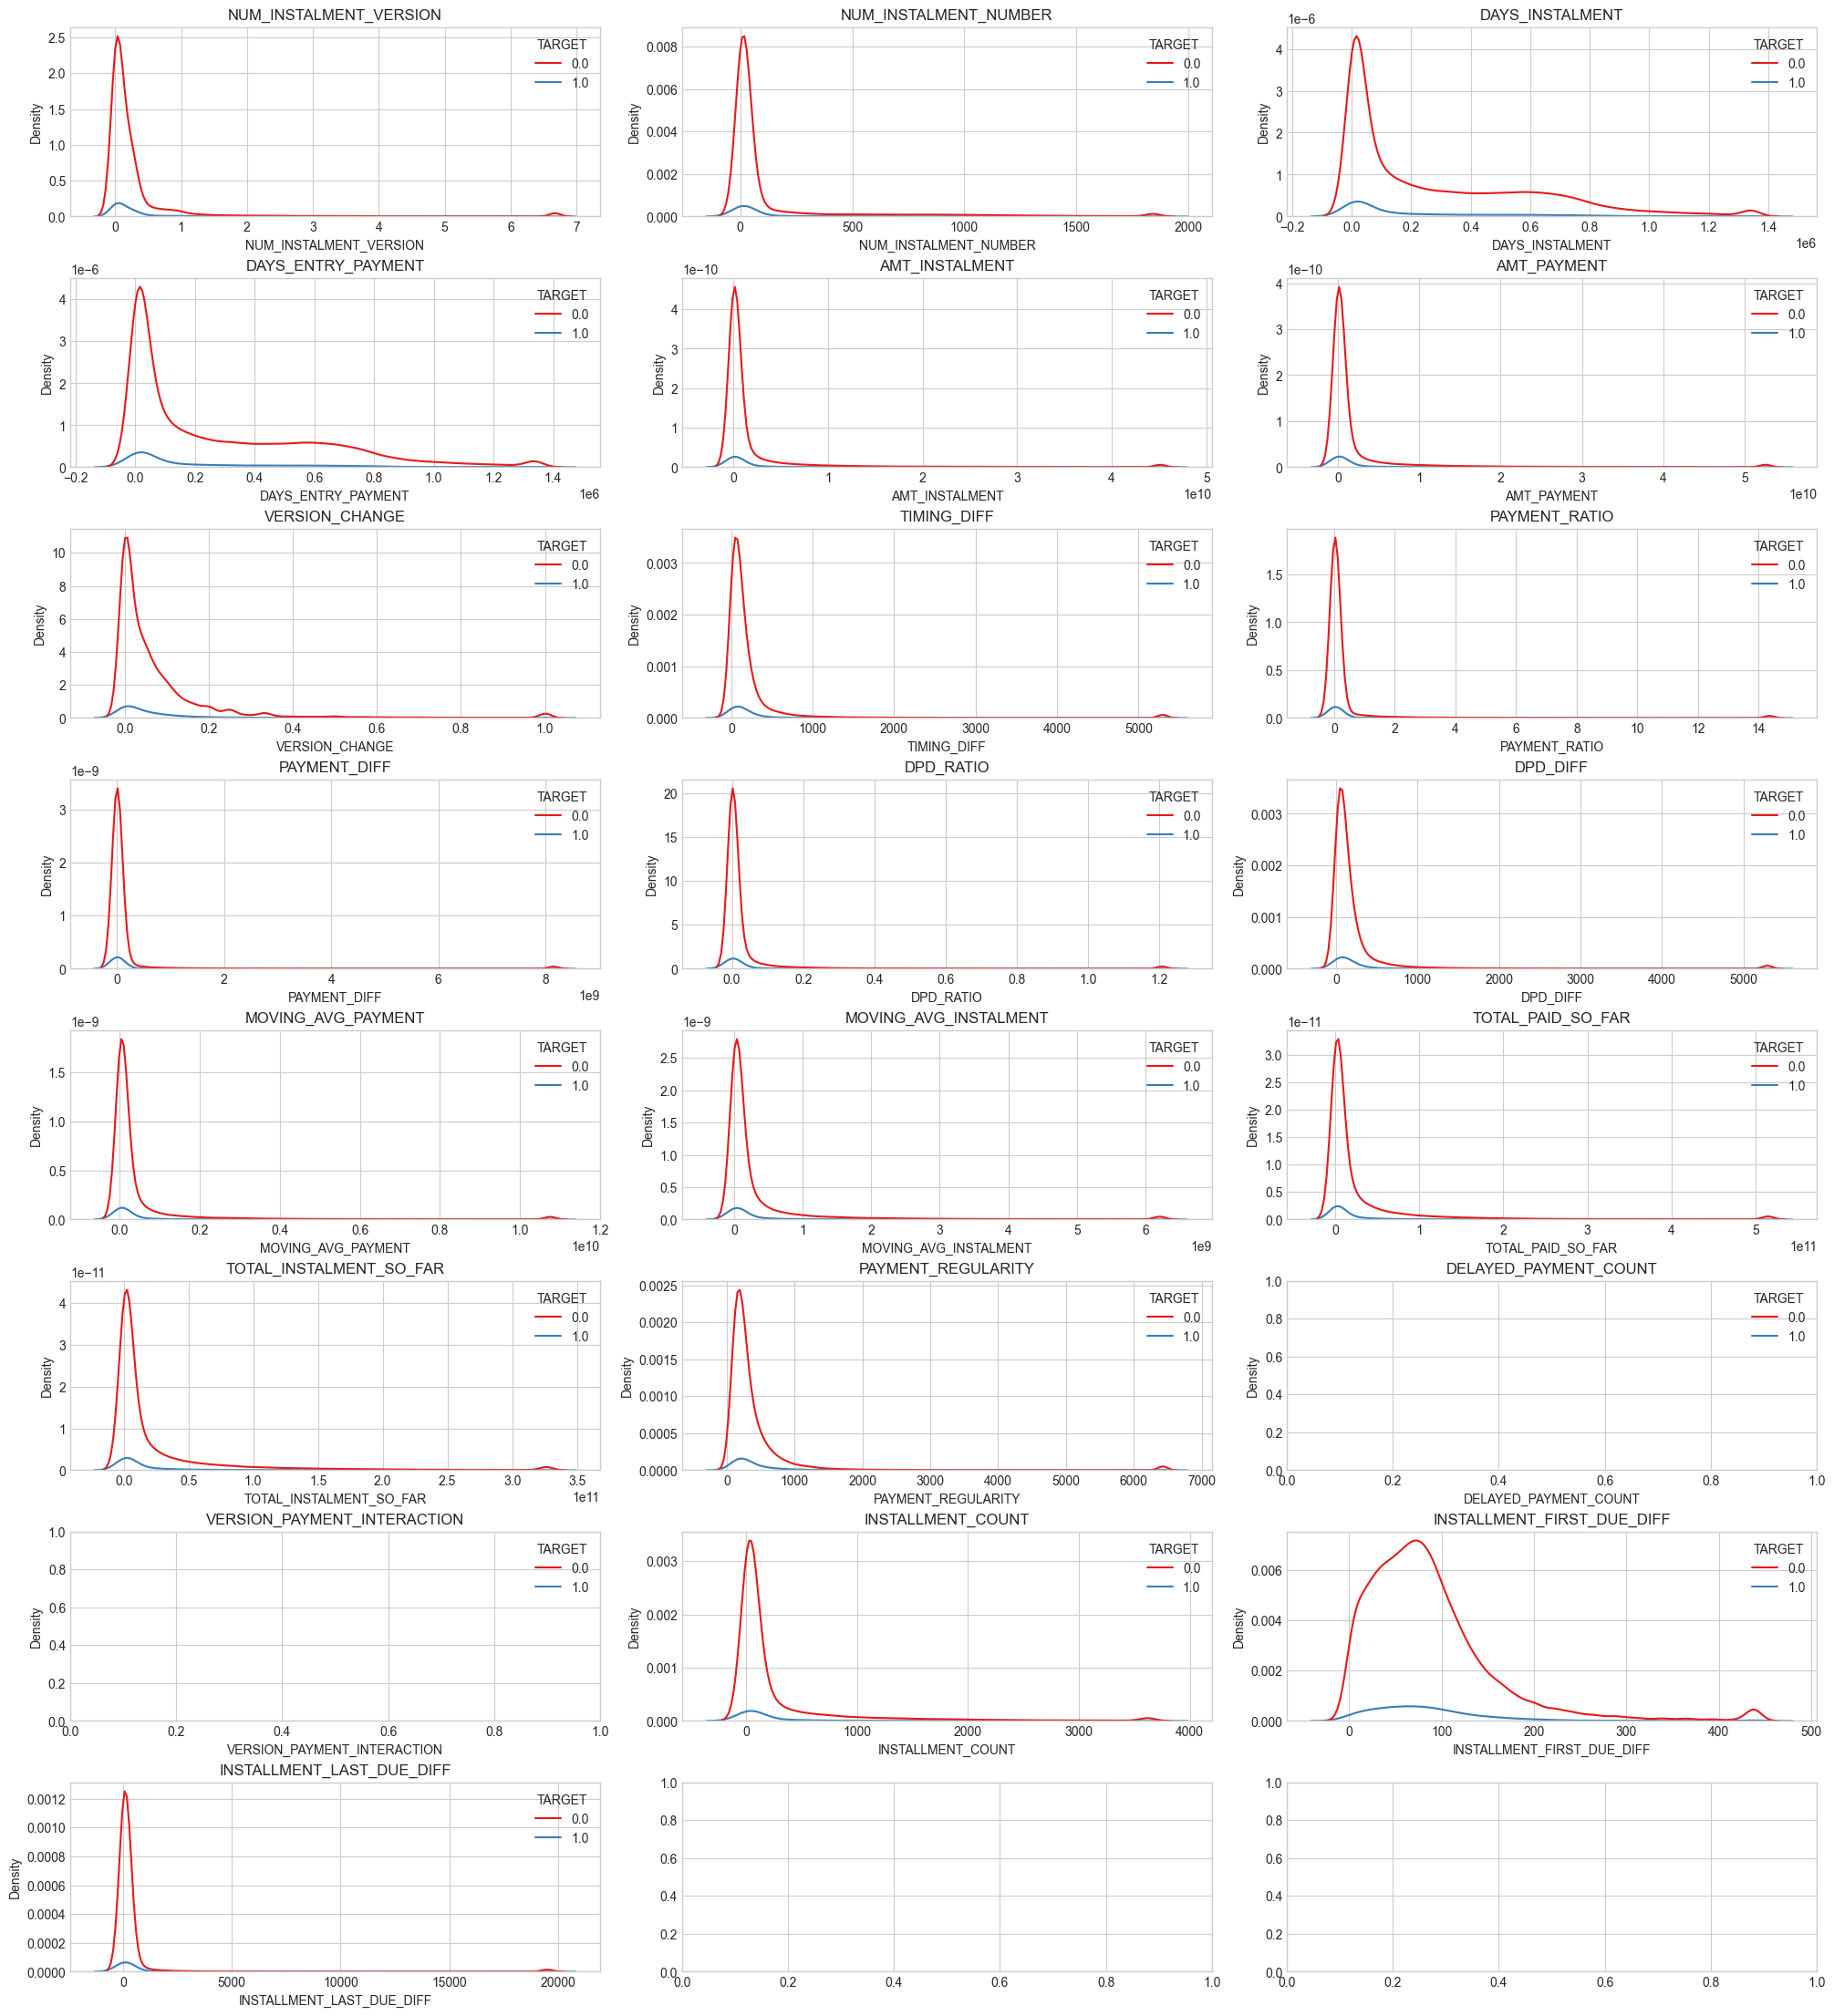

In [27]:
# Plot kde of variance
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.kdeplot(x=var_df[column], ax=ax, hue='TARGET', data=var_df, palette='Set1')
    ax.set_title(column)

plt.show()

# Feature Importance

In [28]:
df = df_copy.copy()
df = create_features(df)
df.drop(columns=['SK_ID_PREV'], inplace=True)

# Replace inf with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Groupby SK_ID_CURR
grouped = df.groupby('SK_ID_CURR').agg(['mean', 'min', 'max', 'var'])

# Flatten column names
grouped.columns = grouped.columns.map('_'.join)

# Merge with target
grouped = grouped.merge(target, on='SK_ID_CURR', how='left')

# Head
grouped.head()

SK_ID_CURR  NUM_INSTALMENT_VERSION_mean  NUM_INSTALMENT_VERSION_min  \
0         0.0                     0.433333                         0.0   
1         1.0                     0.700000                         0.0   
2         3.0                     0.418605                         0.0   
3         4.0                     1.000000                         1.0   
4         5.0                     1.000000                         1.0   

   NUM_INSTALMENT_VERSION_max  NUM_INSTALMENT_VERSION_var  \
0                         2.0                    0.460920   
1                         2.0                    0.266667   
2                         4.0                    0.677741   
3                         1.0                    0.000000   
4                         1.0                    0.000000   

   NUM_INSTALMENT_NUMBER_mean  NUM_INSTALMENT_NUMBER_min  \
0                    7.866667                          1   
1                    6.100000                          1   
2                   12.209302                          1   
3                    3.500000                          1   
4                    5.500000                          1   

   NUM_INSTALMENT_NUMBER_max  NUM_INSTALMENT_NUMBER_var  DAYS_INSTALMENT_mean  \
0                         21                  40.257471           -139.533333   
1                         13                  11.425641           -620.125000   
2                         31                  97.550388           -216.651163   
3                          6                   3.500000          -2282.000000   
4                         10                   9.166667          -1935.000000   

   ...  INSTALLMENT_COUNT_var  INSTALLMENT_FIRST_DUE_DIFF_mean  \
0  ...                    NaN                              NaN   
1  ...                    NaN                              NaN   
2  ...                    NaN                              NaN   
3  ...                    NaN                              NaN   
4  ...                    NaN                              NaN   

   INSTALLMENT_FIRST_DUE_DIFF_min  INSTALLMENT_FIRST_DUE_DIFF_max  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

   INSTALLMENT_FIRST_DUE_DIFF_var  INSTALLMENT_LAST_DUE_DIFF_mean  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

   INSTALLMENT_LAST_DUE_DIFF_min  INSTALLMENT_LAST_DUE_DIFF_max  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   INSTALLMENT_LAST_DUE_DIFF_var  TARGET  
0                            NaN     0.0  
1                            NaN     1.0  
2                            NaN     0.0  
3                            NaN     0.0  
4                            NaN     NaN  

[5 rows x 94 columns]

In [29]:
# Split train test
train_df = grouped[grouped['TARGET'].notnull()]
test_df = grouped[grouped['TARGET'].isnull()]

# Binning Process
optb = BinningProcess(variable_names=train_df.columns.tolist())
optb.fit(train_df, train_df['TARGET'])

summary_table = optb.summary().set_index('name')
summary_table.sort_values('iv', ascending=False, inplace=True)
summary_table

dtype   status  selected n_bins        iv  \
name                                                                       
DPD_RATIO_min              numerical  OPTIMAL      True     13  0.089423   
PAYMENT_REGULARITY_mean    numerical  OPTIMAL      True      9  0.068154   
DUE_FLAG_var               numerical  OPTIMAL      True      8  0.065036   
DUE_FLAG_mean              numerical  OPTIMAL      True      8  0.063275   
PAYMENT_RATIO_mean         numerical  OPTIMAL      True      8  0.052822   
...                              ...      ...       ...    ...       ...   
MOVING_AVG_INSTALMENT_min  numerical  OPTIMAL      True      1       0.0   
MOVING_AVG_PAYMENT_min     numerical  OPTIMAL      True      1       0.0   
DUE_FLAG_min               numerical  OPTIMAL      True      1       0.0   
NUM_INSTALMENT_NUMBER_min  numerical  OPTIMAL      True      1       0.0   
TARGET                     numerical  OPTIMAL      True      1       0.0   

                                 js      gini quality_score  
name                                                         
DPD_RATIO_min              0.011085   0.16347      0.005651  
PAYMENT_REGULARITY_mean    0.008462  0.141908      0.028782  
DUE_FLAG_var               0.008071   0.13491      0.118528  
DUE_FLAG_mean              0.007855  0.133611      0.109163  
PAYMENT_RATIO_mean         0.006558  0.117358      0.089894  
...                             ...       ...           ...  
MOVING_AVG_INSTALMENT_min       0.0         0           0.0  
MOVING_AVG_PAYMENT_min          0.0         0           0.0  
DUE_FLAG_min                    0.0         0           0.0  
NUM_INSTALMENT_NUMBER_min       0.0         0           0.0  
TARGET                          0.0         0           0.0  

[94 rows x 8 columns]

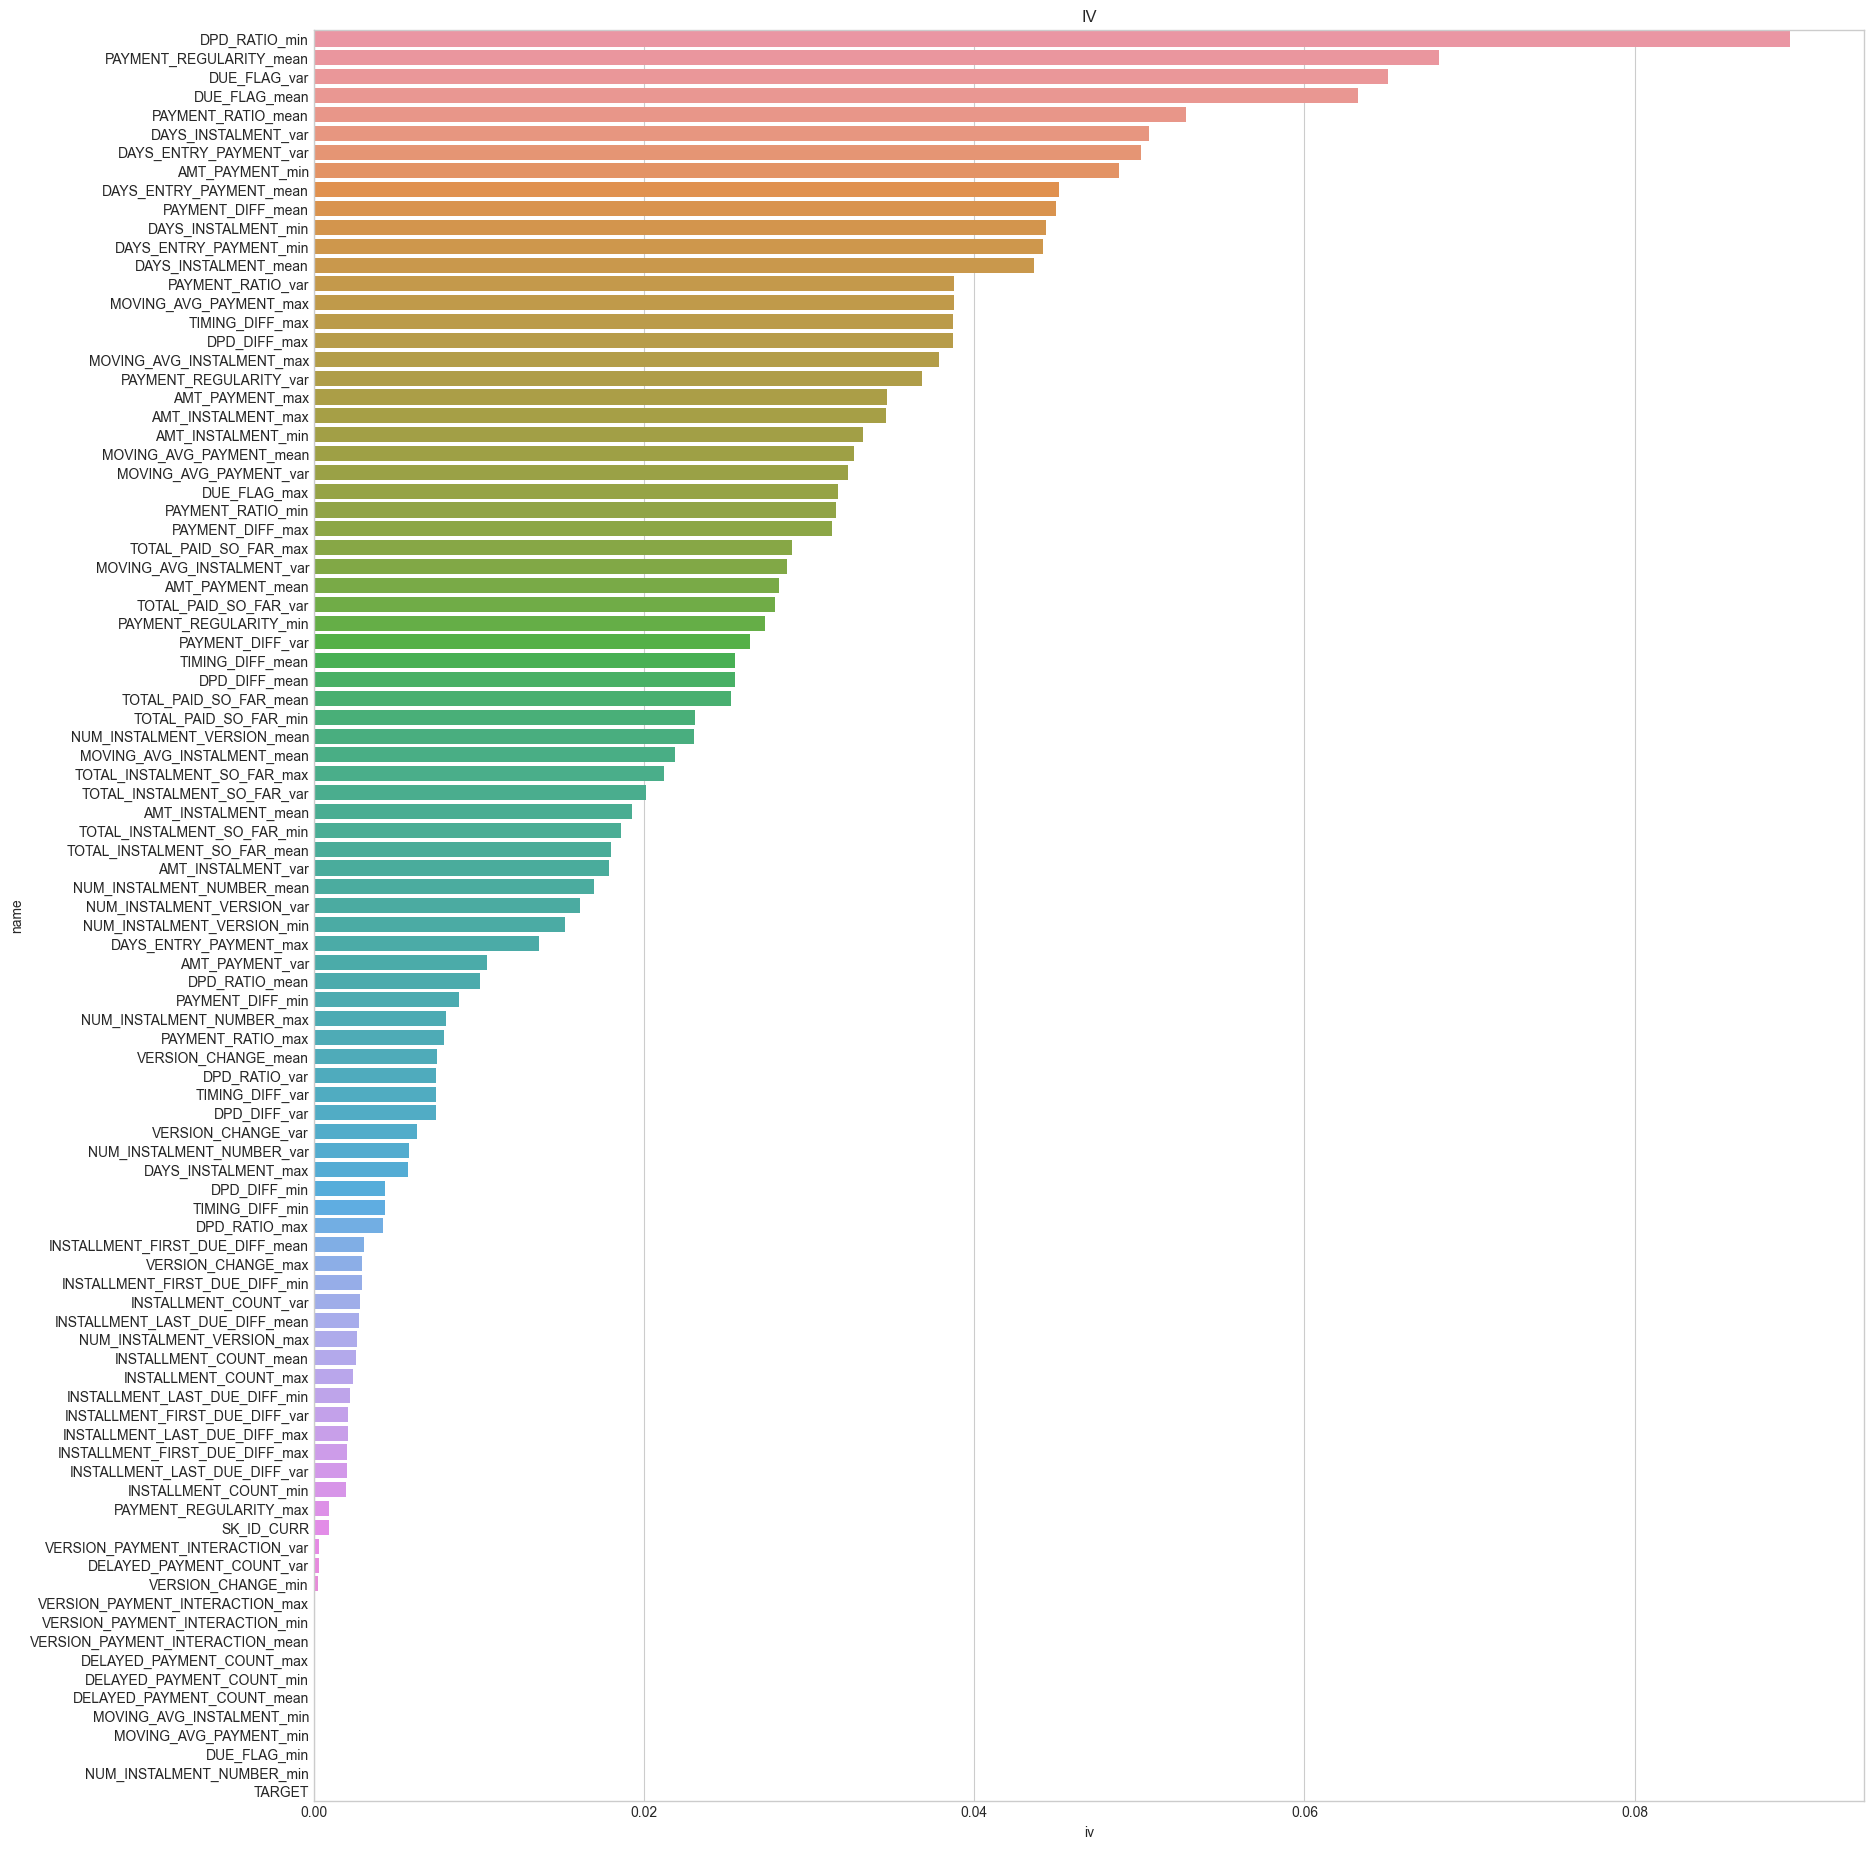

In [30]:
# Plot iv
fig, ax = plt.subplots(figsize=(20, len(summary_table)//4))
sns.barplot(x=summary_table['iv'], y=summary_table.index, ax=ax)
ax.set_title('IV')
plt.show()

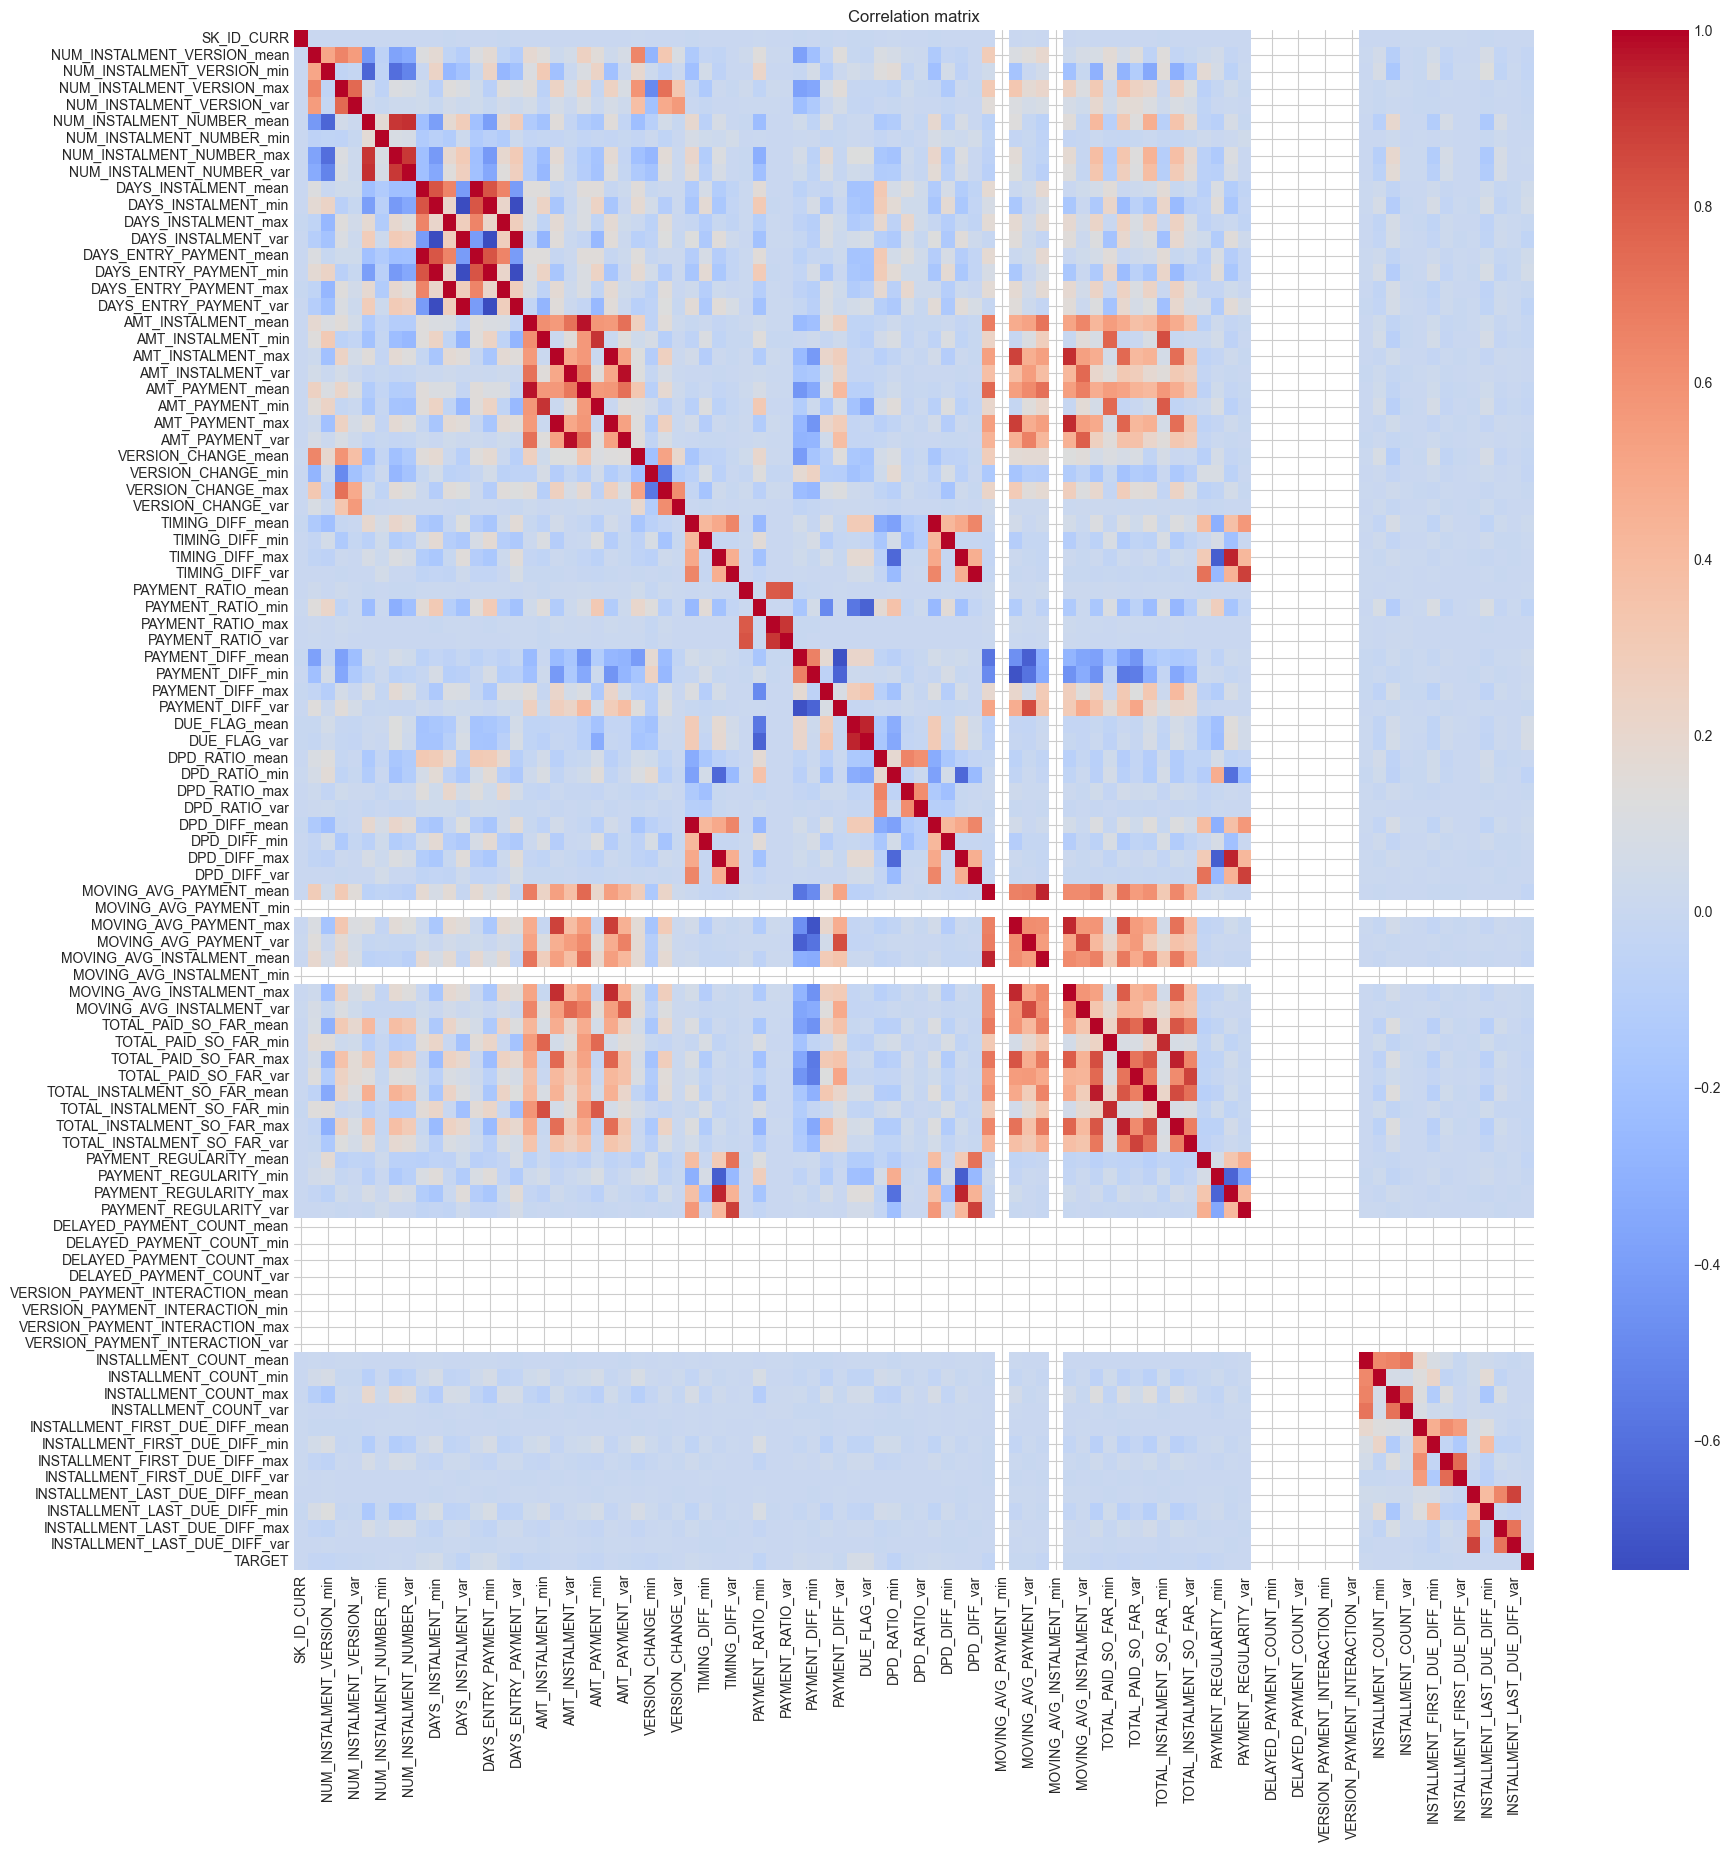

In [31]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(20, 20))
num_cols = train_df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(train_df[num_cols].corr(), ax=ax,cmap='coolwarm')
ax.set_title('Correlation matrix')
plt.show()